# Code

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [2]:
# code for generating timeseries
import sys
sys.path.insert(1, '../sglv_timeseries')

import sglv_timeseries.glv.Timeseries as glv
from sglv_timeseries.noise_parameters import NOISE
from sglv_timeseries.models import MODEL

# code to fit and plot heavy-tailed distributions
from heavytails import fit_heavytail, plot_heavytail, normalizations, plot_cdf_heavytail

# code for plotting
from sglv_timeseries.timeseries_plotting import PlotTimeseries, PlotRankAbundance, \
    PlotTimeseriesComparison

from matplotlib.patches import Patch
from matplotlib import colorbar as mcolorbar
from scipy import stats
from matplotlib.lines import Line2D
from itertools import combinations, count

import sys
sys.path.insert(1, '../logistic_models')

from neutrality_analysis import JensenShannon

# code to load data
sys.path.insert(1, '../helper_functions')

from load_experimental_data import load_experimental_data, load_experimental_abundances

import warnings

import os

load sglv_timeseries


## Import experimental data

In [3]:
df_ts = load_experimental_data()
df_st = load_experimental_abundances()

## Define plot functions

In [4]:
import sys
sys.path.insert(1, '../helper_functions')

from elife_settings import set_elife_settings, ELIFE
from presentation_settings import set_presentation_settings, PRESENTATION
from kaobook_settings import set_kaobook_settings, KAOBOOK


from enum import Enum

class PROJECT(Enum):
    THESIS = 1
    PRESENTATION = 2

In [5]:
ticks = { 'JS' : np.linspace(0,1,6),
          'width' : np.logspace(-2,2,5),
          'pval' : [0,0.05,0.25,0.5,0.75,1.0],
        'diff_width' : [-10,-1,-0.1,0,0.1,1,10],
        'filling' : [0.1, 0.1*np.e, 1, np.e, 10],
        'number' : np.linspace(0,100,6),
        'stability' : [-0.1,-0.01,0,0.01,0.1],
                  'diff_JS' : None, 'diff_pval' : None, 'diff_filling' : None, 
                  'diff_number' : None, 'diff_stability' : None
}

labels = {'JS' : 'Jensen Shannon distance', 'width' : 'Width',
            'pval' : 'p-val width', 'filling' : 'Filling degree',
            'number' : 'Percentage remaining species', 'stability' : 'Stability'}
labels = {**labels, **{'diff_' + key : 'Difference ' + value[0].lower() if value[:6] != 'Jensen' else value[0]
                       + value[1:] for key, value in labels.items()}}


def plot_rankabundances(ts, with_experimental=True, ax_ra=None, raw=False, **kwargs):
    if ax_ra == None or ax_s == None:
        fig = plt.figure(figsize=(8, 3))

        ax_ra = fig.add_subplot(1, 2, 1)

    ra = [t.endpoint for label, t in ts.items()]
    labels = list(ts.keys())

    p = PlotRankAbundance(ra, labels=labels, ax=ax_ra, **kwargs)

    s = [fit_heavytail(x.to_numpy().flatten(), func='lognorm')[0] for x in ra]
        
    if with_experimental == True:
        ra_exp = [df_st["Sanger"], df_ts["David_stool_A"].loc[0, :]]
        labels_exp = ["Sanger", "Stool A"]

        for i, r, c in zip(range(len(ra), len(ra)+len(ra_exp)), ra_exp, ['grey', 'black']):
            p = PlotRankAbundance(
                r, labels=labels_exp, ax=ax_ra, color=c, **kwargs)
    
    if not raw:
        ax_s.set_xticks(range(len(ra_exp)+len(ra)))
        ax_s.set_xticklabels(labels + labels_exp, rotation=90)
        ax_s.set_xlim([-0.5, len(ra_exp)+len(ra)-0.5])

        ax_ra.set_ylim([1e-5, 1e0])
        ax_ra.set_xlim([0.5, 200])

        ax_ra.legend().remove()
    
    return ax_ra

# TODO combine 3 functions into 1

def plot_distributions(con, T=False, verbose=0):
    df = find_ss_constraints(con, T, verbose=verbose)
    df.reindex()
    df = df[df.label == 'a']

    df.index = range(1, len(df)+1)

    fig = plt.figure(figsize=(15,3))

    for index, row in df.iterrows():
        ax = fig.add_subplot(1, len(df), index)
        
        ra = row['species_1':'species_100'].astype(float).to_numpy().flatten()
        params = fit_heavytail(ra, func='lognorm')
        plot_heavytail(ra, params, ax=ax, func='lognorm', add_label=True)
        ax.set_yscale('log')
        
def stability_mesh(constraints):
    th = 1e-3
    stab = df_constraints(dfs['stability'], constraints).pivot_table(values='median', index='noise', columns='max_cap').to_numpy()
    stab = np.abs(stab); stab[stab < th] = 0; stab *= 3/th; stab[stab > 30] = 30
    return stab

def mscatter(x, y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

Fitting of lognormal curves, should we consider very low values?

## Load simulation data

In [6]:
def get_data(file):
    df = pd.DataFrame()
    for i in range(1,29):
        df = df.append(pd.read_csv(file % i))
    df['T'] = 200.0
    
    #df = df.append(pd.read_csv(file % 30))
    
    # keep only first results for duplicated
    df = df[ ~df.drop([str(i) for i in range(5)], axis=1).duplicated(keep='first') ] 
        
    df['mean'] = np.nanmean(df.loc[:,'0':'4'], axis=1)
    df['median'] = np.nanmedian(df.loc[:,'0':'4'], axis=1)
    df['std'] = np.nanstd(df.loc[:,'0':'4'], axis=1)
    df['min'] = np.nanmin(df.loc[:,'0':'4'], axis=1)
    df['max'] = np.nanmax(df.loc[:,'0':'4'], axis=1)
    df.drop(['0', '1', '2', '3', '4'], axis='columns', inplace=True)
    
    return df

folder = 'rankabundance_results/'
df_corr2 = get_data(folder + 'correlation_p%d.csv')
df_JS2 = get_data(folder + 'JS_p%d.csv')
df_w2 = get_data(folder + 'width_p%d.csv')
df_p2 = get_data(folder + 'pval_p%d.csv')
df_n2 = get_data(folder + 'number_p%d.csv')
df_f2 = get_data(folder + 'filling_p%d.csv')

def get_data_stab(file):
    df = pd.DataFrame()
    for i in range(1,32):
        df = df.append(pd.read_csv(file % i))
    
    # keep only first results for duplicated
    #print('before', len(df))
    #print(df.drop([str(i) for i in range(5)], axis=1).duplicated())
    df = df[ ~df.drop([str(i) for i in range(5)], axis=1).duplicated(keep='first') ] 
    #print('after', len(df))
    
    df['mean'] = np.nanmean(df.loc[:,'0':'4'], axis=1)
    df['median'] = np.nanmedian(df.loc[:,'0':'4'], axis=1)
    df['std'] = np.nanstd(df.loc[:,'0':'4'], axis=1)
    df['min'] = np.nanmin(df.loc[:,'0':'4'], axis=1)
    df['max'] = np.nanmax(df.loc[:,'0':'4'], axis=1)
    df.drop(['0', '1', '2', '3', '4'], axis='columns', inplace=True)
    
    return df

folder = 'rankabundance_results/'

#dfs = {'correlation' : get_data_stab(folder + 'correlation_stab%d.csv'),
#      'JS' : get_data_stab(folder + 'JS_stab%d.csv'),
#      'width' : get_data_stab(folder + 'width_stab%d.csv'),
#      'pval' : get_data_stab(folder + 'pval_stab%d.csv'),
#      'number' : get_data_stab(folder + 'number_stab%d.csv'),
#      'filling' : get_data_stab(folder + 'filling_stab%d.csv'),
#      'stability' : get_data_stab(folder + 'stability_stab%d.csv')
#}


def get_data_stab2(file):
    df = pd.DataFrame()
    for i in range(1,20):
        df = df.append(pd.read_csv(file % i, na_values='NAN'))
    
    # keep only first results for duplicated
    #print('before', len(df))
    #print(df.drop([str(i) for i in range(5)], axis=1).duplicated())
    df = df[ ~df.drop([str(i) for i in range(5)], axis=1).duplicated(keep='first') ] 
    #print('after', len(df))
    
    df['mean'] = np.nanmean(df.loc[:,'0':'4'], axis=1)
    df['median'] = np.nanmedian(df.loc[:,'0':'4'], axis=1)
    df['std'] = np.nanstd(df.loc[:,'0':'4'], axis=1)
    df['min'] = np.nanmin(df.loc[:,'0':'4'], axis=1)
    df['max'] = np.nanmax(df.loc[:,'0':'4'], axis=1)
    df.drop(['0', '1', '2', '3', '4'], axis='columns', inplace=True)
    
    return df

folder = 'rankabundance_results/'

dfs = {'correlation' : get_data_stab2(folder + 'correlation__stab%d.csv'),
      'JS' : get_data_stab2(folder + 'JS__stab%d.csv'),
      'width' : get_data_stab2(folder + 'width__stab%d.csv'),
      'pval' : get_data_stab2(folder + 'pval__stab%d.csv'),
      'number' : get_data_stab2(folder + 'number__stab%d.csv'),
      'filling' : get_data_stab2(folder + 'filling__stab%d.csv'),
      'stability' : get_data_stab2(folder + 'stability__stab%d.csv')
}

def df_constraints(df, dic, verbose=False):
    df2 = df.copy()
    for param, value in dic.items():
        df2 = df2[df2[param] == value]
        if verbose:
            print(param, 'length df', len(df2))
    if verbose:
        print(df2)
    return df2

def find_ss_constraints(dic, T=False, verbose=0):
    folder = 'rankabundance/'
    file = folder + 'results_p%d.csv'
    
    col_select = ['noise_max', 'noise', 'max_cap', 'self_int_left', 'self_int_right', 'int_left',
              'int_right', 'growth_rate_left', 'growth_rate_right', 'int_left', 'int_right']
    
    if T:
        file_numbers = [30]
    else:
        file_numbers = range(1, 28)
    
    df = pd.DataFrame(columns = pd.read_csv(file % file_numbers[0], header=0, nrows=2).columns)
    
    for i in file_numbers:
        for chunk in pd.read_csv(file % i, usecols=col_select, header=0, chunksize=500):
            df_i = df_constraints(chunk, dic)
        
            for j in df_i.index:
                if verbose == 1:
                    print(file % i, j)
                
                row_to_add = pd.read_csv(file % i, header=0, skiprows=range(1,j+1), nrows=1)
            
                assert np.all(df.columns == row_to_add.columns)
                
                df = df.append(row_to_add, ignore_index=True)
    return df

FileNotFoundError: [Errno 2] File rankabundance_results/correlation_p1.csv does not exist: 'rankabundance_results/correlation_p1.csv'

## Function to generate extra data

In [ ]:
def two_timeseries(self_int_bounds, growth_rate_bounds, max_cap, noise,
        int_bounds, noise_implementation=NOISE.LANGEVIN_LINEAR, rand_int=0, model=MODEL.MAX):
    N = 100

    params = {}

    omega = np.random.uniform(int_bounds[0], int_bounds[1], [N, N])
    np.fill_diagonal(omega, np.random.uniform(self_int_bounds[0], self_int_bounds[1], [N, 1]))
    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    params['growth_rate'] = np.random.uniform(growth_rate_bounds[0], growth_rate_bounds[1], [N, 1])
    params['initial_condition'] = np.random.normal(1, 0.1, [N, 1])
    params['noise_linear'] = 0

    ss = np.full([N,1], max_cap / N)
    params['maximum_capacity'] = max_cap

    params['noise_linear'] = noise

    dt = 0.01
    tskip = 49
    T = 501.0

    ts = {}
    
    params['initial_condition'] = ss * np.random.normal(1, 0.1, [N, 1])
    ts1 = glv.Timeseries(params, noise_implementation=noise_implementation, dt=dt, tskip=tskip, T=T,
                                seed=int(time.time())+rand_int, model=model)
    params['initial_condition'] = ss * np.random.normal(1, 0.1, [N, 1])
    ts2 = glv.Timeseries(params, noise_implementation=noise_implementation, dt=dt, tskip=tskip, T=T,
                                seed=int(time.time())+rand_int, model=model)
    
    return ts1, ts2

## Function for overview of fits for an abundance distribution

In [7]:
def example_fit_heavytails(d):
    # Define bins.
    bins = np.logspace(-8, -1, 30)
    x_fit = np.logspace(-8, -1, 1000)
    
    # Define figure and axis.
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(121)
    ax_cdf = fig.add_subplot(122)
    
    # Fit different distributions.
    for dist, ls in zip(['norm', 'lognorm', 'pareto'], [':', '-', '-.']):
        params = fit_heavytail(d, func=dist)
        plot_heavytail(d, params, func=dist, ax=ax, linestyle=ls)
        plot_cdf_heavytail(d, params, func=dist, ax=ax_cdf, linestyle=ls)
        
        print(dist, params[:-1], 'pval ', params[-1])
        
    # Set logscale for axis and bounds.
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e2])
    
    # Add colorbar.
    ax_cbar = fig.add_subplot(gs_cbar[0])
    mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
    ax_cbar.set_ylabel('p-value Kolmogorov-Smirnov test')
    
    # Add labels.
    ax = fig.add_subplot(gs_tot[:], frameon=False)
    ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
    ax.set_xlabel('Relative abundance', ha='right', x=1)
    ax.set_ylabel('Normalized frequency')
    
    # Show figure.
    plt.show()

# Introduction

## Experimental data

The rank abundance distribution of experimental data is heavy-tailed, which means that there are many rare species and few abundant ones. 

plankton, human microbiome (gut, palm)


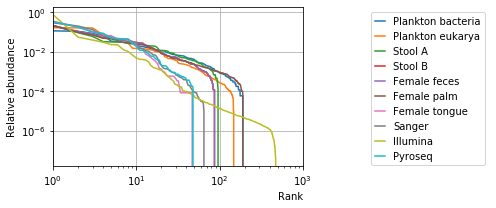

In [9]:
# List of data that will be plotted.
keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B', 
        'Caporaso_F4_feces_L6', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6', 'Sanger', 'Illumina', 'Pyroseq']

titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B', 
          'Female feces', 'Female palm', 'Female tongue', 'Sanger', 'Illumina', 'Pyroseq']


# Define figure and grid for axes.
fig = plt.figure(figsize=(7,3), tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1]) # left axis for rank abundance, right for legend

ax = fig.add_subplot(gs[0])

# Plot rank abundance curve
for key, title in zip(keys, titles):
    if key in df_ts:
        d = np.copy(df_ts[key].values[0,1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0,1:])
        
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)

# Set logarithmic axes
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1,1000])
ax.grid()

# Define axes labels.
ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Relative abundance')

# Set legend.
ax_legend = fig.add_subplot(gs[1])
ax_legend.axis('off')
handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, handlelength=1, ncol=1)

plt.show()

We can fit with power law (dash-dotted), exponential (dotted) and lognormal (full line) distributions to the experimental data. The best results are obtained with lognormal data. The other distributions are rejected with a pvalue less than 0.05 for the Kolmogorov Smirnov test.

We therefore opt for a fit to a lognormal curve. The lognormal distribution can be described by

\begin{equation}
pdf(x) = \frac{1}{s (x - loc) \sqrt{2\pi}} \exp{ \frac{-1}{2} \left(\frac{\ln((x - loc)/scale)}{2 s}\right)^2 }.
\end{equation}

The factor that denotes the width of the distribution in log-scale $s$ is around 2 for experimental data. 

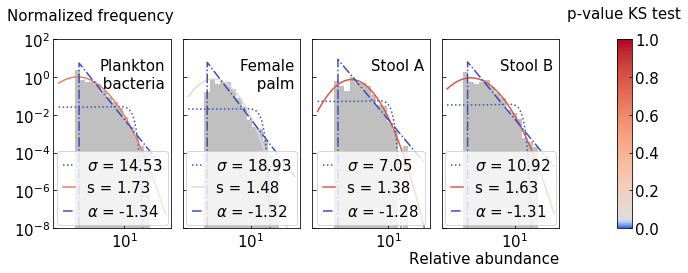

In [27]:
project = PROJECT.PRESENTATION

# List of data that will be plotted.
if project == PROJECT.THESIS:
    set_elife_settings()
    keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B',
        'Caporaso_F4_L_palm_L6', 'Sanger', 'Illumina', 'Pyroseq']
elif project == PROJECT.PRESENTATION:
    set_presentation_settings()
    keys = ['plankton_bacteria', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']

if project == PROJECT.THESIS:
    titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B',
          'Female palm', 'Sanger', 'Illumina', 'Pyroseq']
elif project == PROJECT.PRESENTATION:
    titles = ['Plankton\n bacteria', 'Female\n palm', 'Stool A', 'Stool B']

# Define bins.
bins = np.logspace(-8, -1, 30)
x_fit = np.logspace(-8, -1, 1000)

# Define figure and grids for axes.

if project == PROJECT.THESIS:
    fig = plt.figure(figsize=(ELIFE.FULLWIDTH, 4))  # , tight_layout=True)
    gs = gridspec.GridSpec(2, 4, bottom=0.1, top=0.95,
                       left=0.1, right=0.9, wspace=0.1, hspace=0.3)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.1, top=0.95, left=0.92, right=0.94)
    gs_tot = gridspec.GridSpec(1, 1, bottom=0.05, top=0.95, left=0.05, right=0.9)

elif project == PROJECT.PRESENTATION:
    fig = plt.figure(figsize=(0.75*PRESENTATION.SLIDEWIDTH, 0.5*PRESENTATION.SLIDEHEIGHT))  # , tight_layout=True)
    gs = gridspec.GridSpec(1, 4, bottom=0.15, top=0.85, left=0.1, right=0.8, wspace=0.1)
    
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.15, top=0.85, left=0.88, right=0.9)
    gs_tot = gridspec.GridSpec(1, 1, bottom=0.08, top=0.85, left=0.05, right=0.8)

# Plot the abundance distribution and its heavy tails fit for all communities
for i, key, title in zip(range(len(keys)), keys, titles):
    # Define axis and add title.
    ax = fig.add_subplot(gs[i])  
    if project == PROJECT.THESIS:
        ax.set_title(title, y=1.1)
    elif project == PROJECT.PRESENTATION:
        ax.text(x=0.95, y=0.9, s=title, transform=ax.transAxes, ha='right', va='top')
        
    # Get abundance data.
    if key in df_ts:
        d = np.copy(df_ts[key].values[0, 1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0, 1:])
    
    # Fit different distributions.
    for dist, ls in zip(['norm', 'lognorm', 'pareto'], [':', '-', '-.']):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            params = fit_heavytail(d, func=dist)
            plot_heavytail(d, params, func=dist, ax=ax, linestyle=ls)
    
    if False:
        # Test whether pareto distribution is more likely than power law or truncated power law.
        pvals = ['%.2E' % params[-1]] # pvalue of pareto
        
        # Add pvalues of power law and truncated power law.
        for dist in ['powerlaw', 'trunc_powerlaw']:
            params = fit_heavytail(d, func=dist)
            pvals += ['%.2E' % params[-1]] # save pvalue for printing
        print(title, "pvals [pareto, powerlaw, truncated powerlaw]", pvals)
    
    # Set logarithmic axis and bounds of axis.
    ax.set_yscale('log')
    ax.set_ylim([1e-8, 1e2])
    ax.legend(loc='lower center')
    
    if i % 4 != 0:
        ax.tick_params(left=True, labelleft=False)

# Add colorbar.
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
if project == PROJECT.THESIS:
    ax_cbar.set_ylabel('p-value Kolmogorov-Smirnov test')
if project == PROJECT.PRESENTATION:
    ax_cbar.set_title('p-value KS test', y = 1.08)
# Set x- and y-labels.
ax = fig.add_subplot(gs_tot[:], frameon=False) # axis that combines all axis such that label is shared for all axes
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Relative abundance', ha='right', x=1)
ax.set_ylabel('Normalized frequency', y=1.08, labelpad=10, rotation=0, ha='left')

plt.savefig('../figures_presentation/experimental.pdf')
plt.show()

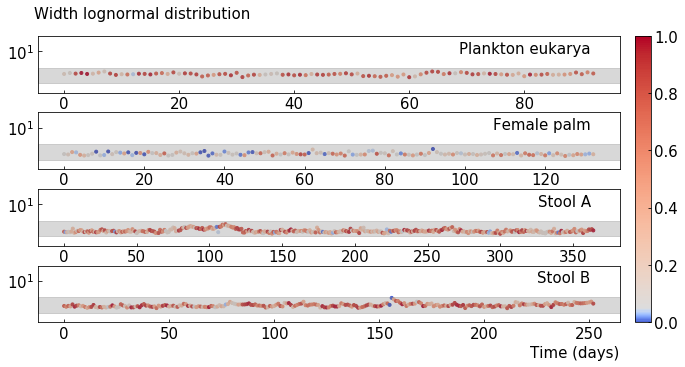

In [17]:
project = PROJECT.PRESENTATION

# List of data that will be plotted.
keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

# Define figure and grid for axes.

if project == PROJECT.THESIS:
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3.))
    gs = gridspec.GridSpec(4,1, hspace=0.3, top=0.95, bottom=0.12, right=0.88)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.95, left=0.9, right=0.92)

elif project == PROJECT.PRESENTATION:
    set_presentation_settings()
    fig = plt.figure(figsize=(0.8*PRESENTATION.SLIDEWIDTH, 0.7*PRESENTATION.SLIDEHEIGHT))
    gs = gridspec.GridSpec(4,1, hspace=0.35, top=0.88, bottom=0.12, right=0.88)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.88, left=0.9, right=0.92)

# Plot width of lognormal abundance distribution as a function of time for all datasets.
for gsi, f, label in zip(gs, keys, titles):
    ax = fig.add_subplot(gsi)
    ax.text(x=0.95, y=0.8 if project == PROJECT.THESIS else 0.7, s=label, transform=ax.transAxes, ha='right')
    data = pd.read_csv('results/experimental/widths_' + f + '.csv', na_values='NAN')
    ax.scatter(data['time'], data['width'], c=data['pval'], cmap=plt.cm.coolwarm,
                       norm=normalizations['pval'])
    ax.set_yscale('log')
    ax.set_ylim([0.5, 30])
    ax.axhspan(1., 3, alpha=0.3, color='grey')

# Set axes labels.
ax.set_xlabel('Time (days)', x=1, ha='right')

ax = fig.add_subplot(gs[:], frameon=False); # axis that combines all axis for combined label.
ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
if project == PROJECT.THESIS:
    ax.set_ylabel('Width lognormal distribution', labelpad=20)
elif project == PROJECT.PRESENTATION:
    ax.set_ylabel('Width lognormal distribution', y=1.05, ha='left', rotation=0)
    
# Draw colorbar with pvalue of fit with lognormal distribution.
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
if project == PROJECT.THESIS:
    ax_cbar.set_ylabel('p-value KS test for lognormal distribution')

# Save and show plot.
plt.savefig('../figures_presentation/experimental_time_dependence.pdf')
plt.show()

What happens for the bad fits?

In [56]:
# Which days are bad fits?

#f = 'David_stool_A'
#f = 'plankton_eukarya'
f = 'Caporaso_F4_L_palm_L6'
data = pd.read_csv('results/experimental/widths_' + f + '.csv', na_values='NAN')

data = data[data['pval'] < 0.05]
print(data['time'].values)
#print(data)

[  3   8  10  11  14  16  17  18  20  34  35  36  37  40  44  46  47  61
  65  72  76  77  84  92  99 113 118 121 126 130 131]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


good day examples
norm (5.681834141646777, 20.134673988731954, 0.3911227391266307) pval  1.60327941054257e-27
lognorm (1.521496190452958, 0.0, 1.0, 0.08511354789313952) pval  0.11027047294743304


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


pareto (0.27438983010087864, 0, 0.030772863228587504, 0.3239289950365529) pval  8.324956275501095e-19


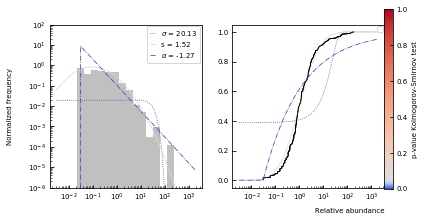

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


norm (4.297996894845962, 11.481060438037767, 0.35819661155415494) pval  5.095432005085798e-23
lognorm (1.4205094898902775, 0.0, 1.0, 0.0860192325363013) pval  0.10369377985663182
pareto (0.3341094170591389, 0, 0.06154573638939431, 0.2985795403202354) pval  5.460707665776161e-16


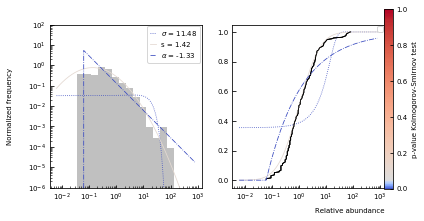

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


norm (4.228282828282829, 15.902742439009048, 0.3958982985550674) pval  4.522099923333517e-28
lognorm (1.482991854696989, 0.0, 1.0, 0.057041030858754116) pval  0.5415604839242872
pareto (0.28370787685189724, 0, 0.030303019361636374, 0.311325104481872) pval  2.7442386667570095e-17


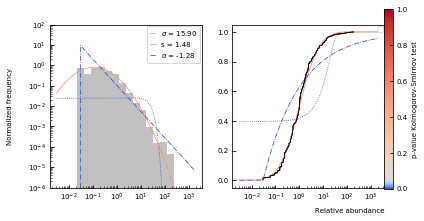

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


bad day examples
norm (9.274871794871792, 42.143723982787854, 0.41336757198393936) pval  1.1400836271732256e-30
lognorm (1.6699421581495406, 0.0, 1.0, 0.10066426239752027) pval  0.03577379603989275
pareto (0.3085170584862583, 0, 0.04999995861840781, 0.28880258442575646) pval  6.775126314583241e-15


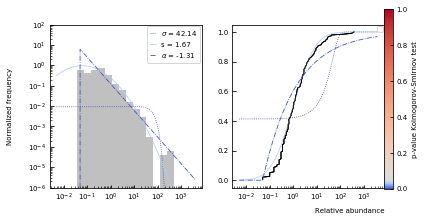

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


norm (10.698969072164946, 44.88630372838158, 0.4063780993067364) pval  1.826651797131782e-29
lognorm (1.6788307190927338, 0.0, 1.0, 0.13278104439332744) pval  0.0019194655209556874
pareto (0.32340589101908146, 0, 0.06666664869388139, 0.26337171191389774) pval  2.299018134926943e-12


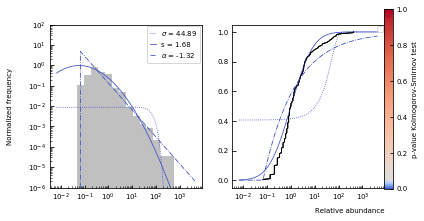

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
No handles with labels found to put in legend.


norm (3.613960113960115, 8.529498066968365, 0.3369888250585763) pval  1.471533557870366e-20
lognorm (1.4070957404379336, 0.0, 1.0, 0.09625799294404636) pval  0.04765319626091499
pareto (0.2597366778535087, 0, 0.025641021628432493, 0.36513699854315584) pval  3.603816892757738e-24


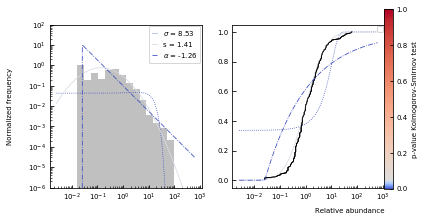

In [57]:
#key = 'David_stool_A'
#good_bad_days = [[0,168, 263], [1,178,293]]

#key = 'plankton_eukarya'
#good_bad_days = [[39], [12]]

key = 'Caporaso_F4_L_palm_L6'
good_bad_days = [[7, 42, 128], [3, 34, 126]]

for label, days in zip(['good', 'bad'], good_bad_days):
    print(label + ' day examples')
    for day in days:
        if key in df_ts:
            d = np.copy(df_ts[key].values[day,1:])

        example_fit_heavytails(d)

In [50]:
if True:
    file = 'results/experimental/widths_plankton_eukarya.csv' #widths_Caporaso_F4_tongue_L6.csv'
    
    if os.path.isfile(file):
        os.remove(file)
        
    from heavytails import fit_heavytail

    with open(file, 'a') as f:
        f.write('time,width,loc,scale,stat,pval\n')
        d = np.copy(df_ts['plankton_eukarya'].values[:, 1:])
        for i in range(len(d)):
            f.write('%d' % i)
            
            pars = fit_heavytail(d[i], func='lognorm')
            
            for par in pars:
                f.write(',')
                f.write('%.4E'%par)
            f.write('\n')

## Width s as measure for rank abundance distribution

The width of the lognormal distribution is a good proxy for the steepness of the rank abundance plot. Larger values of the width $s$ result in steeper curves. We will use this value to measure how well the model approximates the rank abundance curve. From the experimental data we find that the width ranges between 1.57 and 2.78 and we will therefore search for systems with a lognormal distribution with a width between ... and ... 

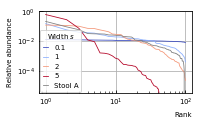

In [18]:
N = 100

ss = [0.1, 1, 2, 5]
locs = [0, 0.1, 1, 5]

fig = plt.figure(figsize=(0.5*ELIFE.TEXTWIDTH,1.5))
cmap = plt.cm.coolwarm

ax_s = fig.add_subplot(1,1,1) 
#ax_loc = fig.add_subplot(1,2,2, sharey=ax_s, sharex=ax_s) 

for s, n in zip(ss, [0, 0.25, 0.75, 1.]):
    r = stats.lognorm.rvs(s=s, size=N)
    r /= sum(r)
    r = np.sort(r)[::-1]
    ax_s.plot(np.arange(1,N+1), r, label=s, color=cmap(n))

if False:
    for loc in locs:
        r = stats.lognorm.rvs(s=2, loc=loc, size=N)
        r /= sum(r)
        r = np.sort(r)[::-1]
        ax_loc.plot(np.arange(1,N+1), r, label=loc)

# experimental data

keys = ['David_stool_A']
titles = ['Stool A']

for key, title in zip(keys, titles):
    if key in df_ts:
        d = np.copy(df_ts[key].values[0,1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0,1:])
        
    d /= np.sum(d)
    ax_s.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title, color='grey')
    #ax_loc.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title, color='grey')
    
plt.grid()

ax_s.set_xscale('log')
ax_s.set_yscale('log')
ax_s.set_ylim([10**(-5.5), 1e0])
ax_s.legend(title='Width $s$')
#ax_loc.legend(title='loc')
#ax_loc.set_xlabel('Rank', x=1, ha='right')
ax_s.set_xlabel('Rank', x=1, ha='right')
ax_s.set_ylabel('Relative abundance')

plt.savefig('figures/parameter_s.pdf')
plt.show()

[ 0.01570897  0.01570897  0.03342304  0.0711122   0.15130119  0.32191451
  0.6849183   1.45725978  3.10052467  6.59680129 14.03562041 14.03562041] [0.         1.73355327 2.03694353 1.53179539 1.79987588 1.01513918
 0.25843986 0.11212415 0.03952412 0.00412811 0.         0.        ]


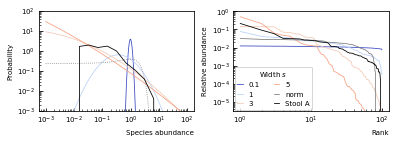

In [33]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2), tight_layout=True)
ax = fig.add_subplot(121)
ax_s = fig.add_subplot(122)

x_fit = np.logspace(-3, 2, 500)

cmap=plt.cm.coolwarm
norm=normalizations['width']

for s in [0.1, 1, 3, 5]:
    pdf_fitted_log = stats.lognorm.pdf(x_fit, s=s, loc=0, scale=1)
    ax.plot(x_fit, pdf_fitted_log, label=s, color=cmap(norm(s)))
    
    r = stats.lognorm.rvs(s=s, size=N)
    r /= sum(r)
    r = np.sort(r)[::-1]
    ax_s.plot(np.arange(1,N+1), r, label=s, color=cmap(norm(s)))

pdf_fitted_norm = stats.norm.pdf(x_fit, loc=1, scale=1)
ax.plot(x_fit, pdf_fitted_norm, linestyle=':', color='grey', label='norm')

r = stats.norm.rvs(loc=1, scale=1, size=N)
r /= sum(r)
r = np.sort(r)[::-1]
ax_s.plot(np.arange(1,N+1), r, label='norm', color='grey')

keys = ['David_stool_A']
titles = ['Stool A']

for key, title in zip(keys, titles):
    if key in df_ts:
        d = np.copy(df_ts[key].values[0,1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0,1:])
        
    d /= np.sum(d); 
    dd = d[d>0]
    dd /= np.mean(dd)
    bins = np.logspace(np.log10(min(dd)), np.log10(max(dd)), 11)
    h, b = np.histogram(dd, bins=bins, density=True)
    x = 10**((np.log10(b[1:]) + np.log10(b[:-1]))/2)
    x = np.append(np.append(x[0], x), x[-1])
    h = np.append(np.append(0, h), 0)
    ax.plot(x, h, 'k')
    print(x, h)
    ax_s.plot(range(1,len(d)+1), np.sort(d)[::-1], 
              label=title, color='k')
    #ax_loc.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title, color='grey')
    
ax_s.set_xscale('log')
ax_s.set_yscale('log')
ax_s.set_ylim([10**(-5.5), 1e0])
ax_s.legend(title='Width $s$', ncol=2)
ax_s.set_xlabel('Rank', x=1, ha='right')
ax_s.set_ylabel('Relative abundance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.set_xlabel('Species abundance', x=1, ha='right')
ax.set_ylabel('Probability')
#ax.legend(title='Width $s$')
plt.savefig('figures/width_examples.pdf')
plt.show()

In [15]:
np.logspace(-3, np.log10(2), 10)

array([1.00000000e-03, 2.32691817e-03, 5.41454816e-03, 1.25992105e-02,
       2.93173318e-02, 6.82190321e-02, 1.58740105e-01, 3.69375235e-01,
       8.59505945e-01, 2.00000000e+00])

## Measure for noisyness

Level of noise can make sure that timeseries does not go too far but far enough from equilibrium. What parameter could we use to measure this?

- autocorrelation 
- Jensen Shannon distance between different time steps
- Noise color

The Jensen Shannon distance does not depend on the sampling as do the autocorrelation and noise color, therefore we prefer this JS distance. 

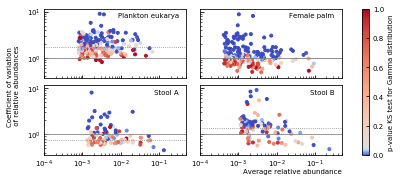

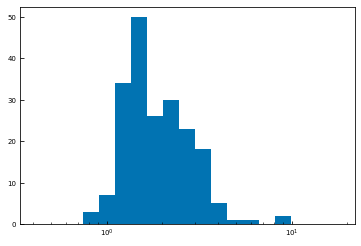

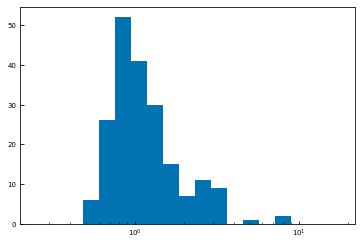

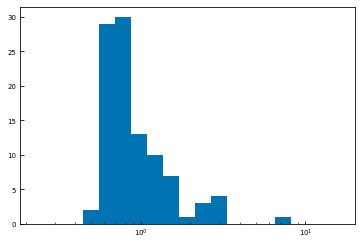

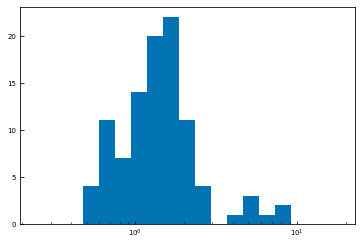

In [10]:
# Variance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2.5))  # , tight_layout=True)
gs = gridspec.GridSpec(2, 2, bottom=0.12, top=0.93,
                       left=0.1, right=0.85, wspace=0.1, hspace=0.1)
gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.93, left=0.9, right=0.92)
gs_tot = gridspec.GridSpec(1, 1, bottom=0.07, top=0.93, left=0.05, right=0.85)

keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

for i, key, title in zip(range(len(keys)), keys, titles):
    ax = fig.add_subplot(gs[i], sharey=ax if i > 0 else None, sharex=ax if i > 0 else None)
    #ax.set_title(title)
    ax.text(0.95, 0.95, title, 
                ha='right', va='top', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    
    d = df_ts[key].drop('time', axis=1)
    d = d.div(d.sum(axis=1), axis=0)
    
    x = d.mean(axis=0)
    y = d.std(axis=0)/x

    if True:  # Grilli params
        #pval = [stats.kstest(d[species], 'gamma',
        #                     args=((np.mean(d[species])**2/np.var(d[species]), 0,
        #                            np.var(d[species])/np.mean(d[species]))))[1]
        #        for species in d]
        # don't use zeros
        pval = [stats.kstest(d[species][d[species]>0], 'gamma',
                             args=((np.mean(d[species][d[species]>0])**2/np.var(d[species][d[species]>0]), 0,
                                    np.var(d[species][d[species]>0])/np.mean(d[species][d[species]>0]))))[1]
                for species in d]
    else:
        pval = np.empty_like(x)
        for i, species in enumerate(d):
            a_fit, loc_fit, scale_fit = stats.gamma.fit(x,
                                                        np.mean(d[species])**2/np.var(d[species]),
                                                        loc=0, scale=np.var(d[species])/np.mean(d[species]))
            y[i] = a_fit
            pval[i] = stats.kstest(d[species], 'gamma', args=(
                (a_fit, loc_fit, scale_fit)))[1]
            if i % 10 == 0:
                print(a_fit, np.mean(d[species])**2/np.var(d[species]))
                print(pval[i])
    
    plt.figure()
    bins = np.logspace(np.log10(np.min(y)/2), np.log10(np.max(y)*2),20)
    plt.hist(y, bins=bins)
    plt.xscale('log')
    
    ax.scatter(x, y, c=pval, cmap='coolwarm',
               norm=normalizations['pval'])  # color='grey')

    x_fit = np.logspace(np.log10(np.nanmin(x[x > 0])/2),
                        np.log10(np.nanmax(x[x > 0])*2), 100)
    ax.axhline(y=np.median(y), linestyle=':', color='grey')
    ax.axhline(y=1, linestyle='-', color='grey')

    #r2 = r2_score(y, x)
    #ax.text(0.9, 0.1, '%.2f' % r2, ha='right', fontsize=10, transform = ax.transAxes)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([x_fit[0], x_fit[-1]])
    if i % 2 != 0:
        ax.tick_params(labelleft=False)
    if i < 2:
        ax.tick_params(labelbottom=False)
    
ax.set_xlim([1e-4,5e-1])
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])

ax_cbar.set_ylabel('p-value KS test for Gamma distribution')
ax = fig.add_subplot(gs_tot[:], frameon=False)
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Average relative abundance', ha='right', x=1)
ax.set_ylabel('Coefficient of variation\n of relative abundances')

fig.savefig('figures/experimental_variation.pdf')
plt.show()

1.6336098827894223 1.850240195962073


Text(0, 0.5, 'Probability')

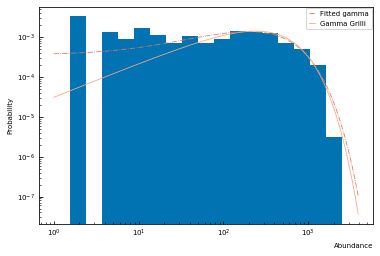

In [169]:
keys = ['plankton_eukarya', 'David_stool_A', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

d = df_ts[keys[1]]

x = d.species_3.to_numpy()
a_fit, loc_fit, scale_fit = stats.gamma.fit(x)

x_fit = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 100)
bins = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 20)

plt.hist(x, density=True, bins=bins)

norm=normalizations['pval']

print(a_fit, (np.mean(x)**2/np.var(x)))

for a, loc, scale, ls, label in zip([a_fit, (np.mean(x)**2/np.var(x))],
                             [loc_fit, 0],
                             [scale_fit, np.var(x)/np.mean(x)],
                             ['-.', '-'],
                             ['Fitted gamma', 'Gamma Grilli']):
    stat, pval = stats.kstest(x, 'gamma', args=((a, loc, scale)))
    plt.plot(x_fit, stats.gamma.pdf(x_fit, a, loc, scale), c=plt.cm.coolwarm(norm(pval)),  
             linestyle=ls, label=label)
    
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Abundance', x=1, ha='right')
plt.ylabel('Probability')

(0.0037037037037037034, 5377.955555555555)

<Figure size 864x864 with 0 Axes>

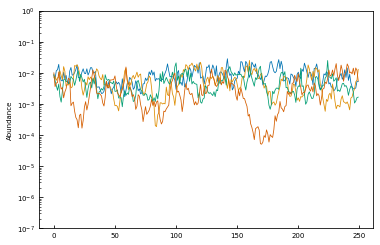

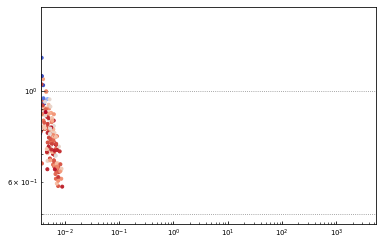

In [212]:
def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5, 
                         minmigration=0.4, maxmigration=0.4, 
                         minextinction=0.3, maxextinction=0.3):
    interaction = np.random.uniform(minint,maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1-connectance, connectance]) # connectance
    np.fill_diagonal(interaction, -1.) # self-interaction
    
    growth_rate = np.full([S,1], 0.3)
    immigration = np.random.uniform(minmigration,maxmigration, [S,1]);
    extinction = np.random.uniform(minextinction,maxextinction, [S,1]); 
    
    return interaction, growth_rate, immigration, extinction

S = 200        # species in metacommunity
s = None      # species in local community
SIS = []
SISfactor = 200
sites = 10000

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

migration = 0
connectance = 0.1
minint = -0.1; maxint = 0.1

fig_ra = plt.figure(figsize=(12,12))
gs_ra = gridspec.GridSpec(3,3)

interaction, growth_rate, immigration, extinction = random_parameter_set(S, 
             minmigration=migration, maxmigration=migration, connectance=connectance,
             minint=minint, maxint=maxint)
initcond = np.random.uniform(0, 10, [S,1])
#np.fill_diagonal(interaction, np.random.uniform(-10,-1, len(interaction)))

params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
                          'extinction_rate' : extinction, 'initial_condition' : initcond, 
              'noise_linear' : 0.5, 'growth_rate' : growth_rate}
            
ts = glv.Timeseries(params, T = 250, dt=0.01, tskip=99).timeseries
ts.set_index('time', inplace=True)
ts = ts.div(ts.sum(axis=1), axis=0) 
ts.reset_index(level=0, inplace=True)

pt = PlotTimeseries(ts)
pt.ax.set_ylim([1e-7, 1e0])

ts.set_index('time', inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.nanmean(ts, axis=0)
y = np.nanstd(ts, axis=0)/x
pval = [stats.kstest(ts[species], 'gamma',
                             args=((np.mean(ts[species])**2/np.var(ts[species]), 0,
                                    np.var(ts[species])/np.mean(ts[species]))))[1]
                for species in ts]
plt.scatter(x, y, c=pval, norm=normalizations['pval'], cmap=plt.cm.coolwarm)

plt.axhline(y=0.5, linestyle=':', color='grey')
plt.axhline(y=1, linestyle=':', color='grey')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x_fit[0], x_fit[-1]])

For experimental data, the median Jensen Shannon distance between different time points of the same time series ranges from 0.3 to 0.4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


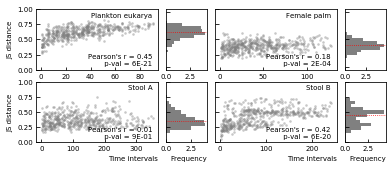

In [19]:
from scipy.stats import pearsonr

keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2.5), tight_layout=True)
gs = gridspec.GridSpec(2,4, width_ratios=[3,1,3,1], hspace=0.2, wspace=0.1, 
                       top=0.92, bottom=0.18, left=0.1, right=0.98)

for i, key, title in zip(range(len(keys)), keys, titles):
    ax = fig.add_subplot(gs[2*i], sharey=ax if i>1 else None)
    axhist = fig.add_subplot(gs[2*i+1], sharey=ax if i>1 else None)
    
    ts = df_ts[key]; 
    ts = ts[[col for col in ts.columns if col.startswith('species')]].values
    
    c = list(combinations(range(len(ts)),2))
    np.random.shuffle(c)

    N = 500
    JS = np.zeros(N)
    ti = np.zeros(N)
    
    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(ts[comb[0]] + 1e-10, ts[comb[1]] + 1e-10)
        ti[ii] = np.abs(comb[0] - comb[1]) # time interaval
    
    if sum(~np.isnan(JS)) > 2:
        corr, pval = pearsonr(JS[(~np.isnan(JS))&(ti>14)], ti[(~np.isnan(JS))&(ti>14)])
    else:
        corr, pval = np.nan, np.nan
    
    ax.text(0.95, 0.95, title, 
                ha='right', va='top', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    ax.text(0.95, 0.05, "Pearson's r = %.2f\n p-val = %.0E" % (corr, pval), 
                ha='right', va='bottom', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    if i >= 2:
        ax.set_xlabel('Time intervals', x=1, ha='right')
        axhist.set_xlabel("Frequency", x=1, ha='right')
    
    ax.scatter(ti, JS, s=3, color='grey', alpha=0.3)
    ax.set_ylim([0,1])
    axhist.hist(JS, bins=np.linspace(0,1,20), density=True, orientation='horizontal', color='grey')
    axhist.axhline(y=np.median(JS), label='median', color='red', linestyle=':')
    
    if i % 2 == 0:
        ax.set_ylabel('JS distance')
    else:
        ax.tick_params(labelleft=False)
    #if i == len(keys)-1:
    #    axhist.legend()
    axhist.tick_params(labelleft=False)

plt.savefig('figures/experimental_JS.pdf')
plt.show()

and the median Jensen Shannon distance between bacterial composition of the stool of different individuals ranges from 0.4 to 0.5.

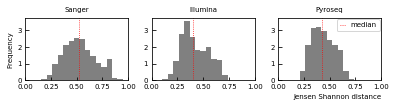

In [45]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,1.5), tight_layout=True)

for i, key in enumerate(df_st.keys(), start=1):
    ax = fig.add_subplot(1, len(df_st.keys()), i, sharey=ax if i>1 else None)
    ax.set_title(key)

    df = df_st[key].copy()
    
    if '-1' in df.columns:
        df.drop('-1', axis=1, inplace=True)
    elif '1' in df.columns:
        df.drop('1', axis=1, inplace=True)
        
    c = list(combinations(df.index, 2))

    N = min(len(c), 1000)

    JS = np.zeros(N)

    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(df.loc[comb[0]] + 1e-10, df.loc[comb[1]] + 1e-10)

    ax.hist(JS, bins=np.linspace(0,1,20), density=True, color='grey')
    ax.set_xlim([0,1])
    ax.axvline(x=np.median(JS), label='median', color='red', linestyle=':')
    
    if i == len(df_st.keys()):
        ax.set_xlabel("Jensen Shannon distance", ha='right', x=1)
        ax.legend()
    if i == 1:
        ax.set_ylabel("Frequency")

plt.savefig('figures/experimental_JS2.pdf')
plt.show()

$\newcommand{\Nmax}{N_\text{max}}$
$\newcommand{\Nspec}{N_\text{spec}}$

## Maximal capacity key for heavy-tailed distributions?

Solé reported that heavy-tailed distributions can be obtained through an individual based modeling approach with a fixed maximum number of species. stochastic cellular automaton, microbial communities (Coyte 2015).

Maximal capacity can be interpreted as limits by fundamental resources (water, sugars?, space)

We can add a maximal capacity to logistic and gLV models by multiplying all positive growth terms with a growth probability $\gamma$ that depends on the total number of individuals $\Nmax$, $\gamma = 1 - \sum_j x_j / \Nmax$. In gLV, the growth vector $g$ can be split into its positive and negative components $g = g^+ + g^-$. Species for which the growth term is positive can grow in the absence of other species, species with a strictly negative growth term will need to be positively influenced by other species to have a non-zero positive steady state abundance since the self-interaction is always negative. The interaction matrix can be split in an equivalent way into its positive and negative parts: $\omega = \omega^+ + \omega^-$. Only the positive growth terms are multiplied by the probability for growth that depends on the fraction of "empty space" that remains. Furthermore, we limit the probability for growth $\gamma$ such that it is a value between $0$ and $1$. This constraint is important, because we could imagine a steady state starting with more individuals than the maximal capacity. Without a limit at $0$ $\gamma$ could become negative and the growth term becomes a death term. For population based generalized Lotka-Volterra models, a maximal number of species can be implemented as follows:

\begin{align}
d x_i(t) = \left(\lambda_i + g_i^- x_i(t) + \sum_j \omega_{ij}^- x_i(t) x_j(t) + \gamma(t) \left( g_i^+ x_i(t) + \sum_j \omega_{ij}^+ x_i x_j\right)\right) dt \\
\gamma(t) = max(0, 1 - \frac{\sum_i x_i(t)}{N_\text{max}})
\end{align}

Higher order terms also in (Hoffman 2007).

# Maximal capacity model with all species equivalent

First we consider the easy case without interactions: the logistic equations.

## Logistic equations with a maximal capacity are generalized Lotka-Volterra equations

\begin{align}
d x_i(t) = \left(\lambda_i + g_i^- x_i(t) + \left( 1 - \frac{\sum_j x_j(t)}{\Nmax} \right) g_i^+ x_i(t) \right) - K_{i} x_i^2 dt \\
d x_i(t) = \left(\lambda_i + ( g_i^- + g_i^+ ) x_i(t) -  \sum_{j} \left( \frac{g_i^+}{\Nmax}  + K_{i}\delta_{ij}\right) x_i(t)x_j(t) \right) dt
\end{align}

We can identify an interaction matrix $\omega$ where $\omega_{ij} = \frac{g_i^+}{N_\text{max}}$ and $\omega_{ii} = \frac{g_i^+}{N_\text{max}}  + K_{i}$. Logistic equations with a maximal capacity can be interpreted as generalized Lotka-Volterra equations. We only need to be careful to not use initial conditions where $\sum_j x_j(0) > N_\text{max}$. A smaller maximal capacity is translated into more competition in the gLV model.

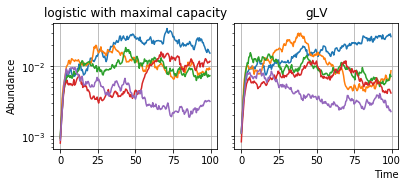

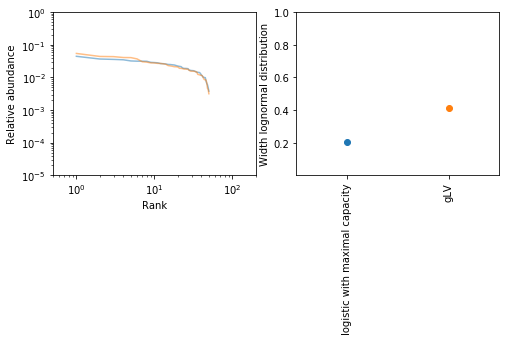

In [12]:
def maximal_capacity_vs_shifted_interactions():
    N = 50

    params = {}

    steadystate = np.ones([N,1])

    # no interaction
    omega = np.zeros([N, N]);
    np.fill_diagonal(omega, -1)
    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    growth_rate = - (omega).dot(steadystate)
    params['growth_rate'] = growth_rate
    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1, 0.1, steadystate.shape)
    params['noise_linear'] = 1e-1
    
    ts = {}

    dt = 0.01
    tskip = 49  # 50
    T = 100.0
    
    max_cap = 0.01 * np.sum(steadystate)
    params['maximum_capacity'] = max_cap
    params['initial_condition'] = 0.001 * np.copy(steadystate) * np.random.normal(1, 0.1, steadystate.shape)

    ts['logistic with maximal capacity'] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                  seed=int(time.time()), model=MODEL.MAX)
    
    pos_growth_rate = growth_rate.clip(min=0)
    params['interaction_matrix'] = params['interaction_matrix'] - pos_growth_rate / max_cap
    ts['gLV'] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                      seed=int(time.time()), model=MODEL.GLV)

    return ts

ts = maximal_capacity_vs_shifted_interactions()

p1 = PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])

p2 = plot_rankabundances(ts, with_experimental=False)
plt.ylim([1e-4,1e0])
plt.show()

## Effect time

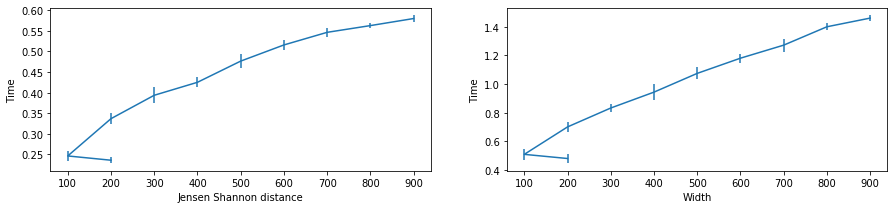

In [37]:
dfs = [df_JS, df_w]
labels = ['Jensen Shannon distance', 'Width']

noise = 0.05
max_cap = 0.01

fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, len(dfs))

for i, label, df in zip(count(), labels, dfs):
    df_i = df_constraints(df, {'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1,
                          'int_left' : 0, 'int_right' : 0, 
                                  'growth_rate_left' : 1, 'growth_rate_right' : 1,
                             'noise' : noise, 'max_cap' : max_cap})

    ax = fig.add_subplot(gs[i])
    
    ax_mat = ax.errorbar(df_i['T'], df_i['mean'], df_i['std'])
    #ax.set_xticks(range(len(df_i.columns)))
    #ax.set_xticklabels(df1['T'], rotation=90)
    ax.set_xlabel(label)
    ax.set_ylabel('Time')

plt.show()

In [38]:
int_bounds = [0,0]
self_int_bounds = [-1, -1]
noise = 0.15
growth_rate_bounds = [1, 1]
max_cap = 0.05

N = 100

params = {}

omega = np.random.uniform(int_bounds[0], int_bounds[1], [N, N])
np.fill_diagonal(omega, np.random.uniform(self_int_bounds[0], self_int_bounds[1], [N, 1]))
params['interaction_matrix'] = omega
params['immigration_rate'] = np.zeros([N, 1])
params['growth_rate'] = np.random.uniform(growth_rate_bounds[0], growth_rate_bounds[1], [N, 1])
params['initial_condition'] = np.random.normal(1, 0.1, [N, 1])
params['noise_linear'] = 0

ss = np.full([N, 1], max_cap / N)
params['maximum_capacity'] = max_cap

params['noise_linear'] = noise

dt = 0.01
tskip = 99
T = 900.0

params['initial_condition'] = ss * np.random.normal(1, 0.1, [N, 1])

ts = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                    seed=int(time.time()), model=MODEL.MAX).timeseries


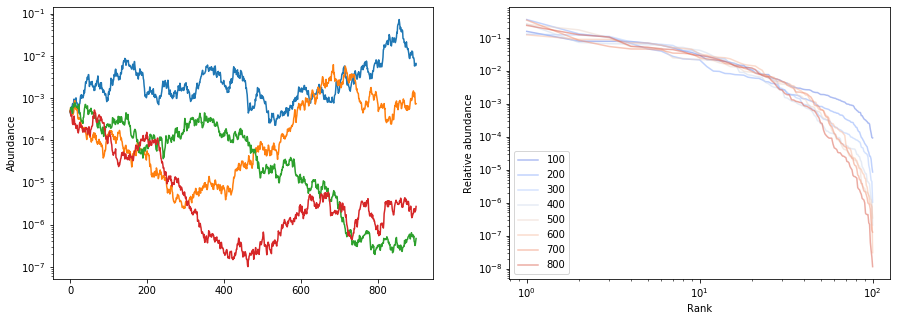

In [39]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
PlotTimeseries(ts, ax=ax)

ax = fig.add_subplot(1,2,2)
for i in range(100, 900, 100):
    ra = ts[ts.time == i].loc[:,'species_1':'species_100']
    PlotRankAbundance(ra, ax=ax, labels=i, color=plt.cm.coolwarm(i/900))
plt.show()

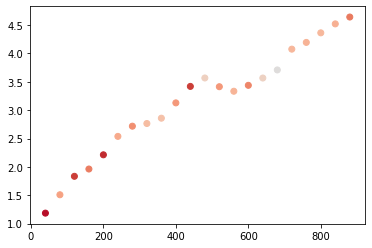

In [40]:
Ts = np.arange(40, 900-1, 40)
ss = np.nan * Ts
pvals = np.nan * Ts

for i, t in enumerate(Ts):
    ra = ts[ts.time == t].loc[:,'species_1':'species_100'].to_numpy().flatten()
    s, loc, scale, stat, pval = fit_heavytail(ra, func='lognorm')
    ss[i] = s
    pvals[i] = pval
    
plt.scatter(Ts, ss, c=pvals, cmap=plt.cm.coolwarm, norm=normalizations['pval'])
plt.show()


## Smaller maximal capacity leads to slower dynamics

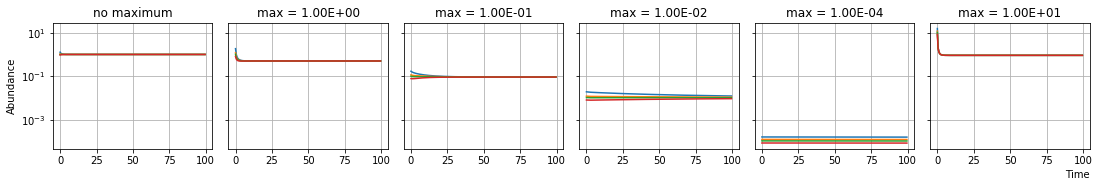

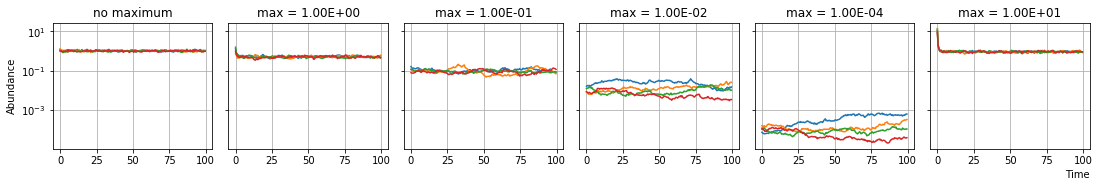

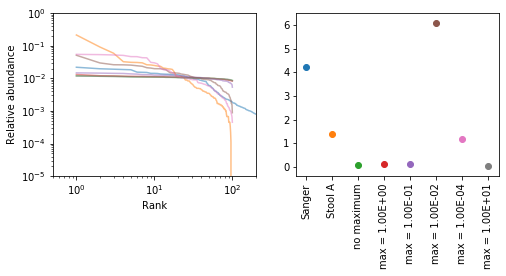

In [21]:
def rank_abundances_maximal_capacity_varying_maxima():
    N = 100

    params = {}

    steadystate = np.ones([N,1])
    omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)
    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    params['growth_rate'] = - (omega).dot(steadystate)
    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1, 0.1, steadystate.shape)
    params['noise_linear'] = 1e-1
    
    params_nonoise = params.copy()
    params_nonoise['noise_linear'] = 0
    
    ts = {}
    ts_nonoise = {}
    
    dt = 0.01
    tskip = 49  # 50
    T = 100.0

    ts['no maximum'] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                      seed=int(time.time()), model=MODEL.GLV)
    ts_nonoise['no maximum'] = glv.Timeseries(params_nonoise, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                      seed=int(time.time()), model=MODEL.GLV)
    
    maxima = [1, 0.1, 1e-2, 1e-4, 10]

    for i in maxima:
        params['maximum_capacity'] = i * sum(steadystate)
        params['initial_condition'] = np.copy(
                steadystate) * np.random.normal(i, i*0.3, steadystate.shape)
        
        ts['max = %.2E' % i] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                  seed=int(time.time()), model=MODEL.MAX)
        
        params_nonoise = params.copy()
        params_nonoise['noise_linear'] = 0
        
        ts_nonoise['max = %.2E' % i] = glv.Timeseries(params_nonoise, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                  seed=int(time.time()), model=MODEL.MAX)
        
    return ts, ts_nonoise

ts, ts_nonoise = rank_abundances_maximal_capacity_varying_maxima()

p1 = PlotTimeseriesComparison([t.timeseries for label, t in ts_nonoise.items()], 
                             composition=['ts'], titles=[label for label, t in ts_nonoise.items()])

p2 = PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])

p3 = plot_rankabundances(ts)
#p3.ax.set_ylim([1e-4, 1e0])
#plt.savefig('figures/rank_abundance/maximal_capacity1.png')
plt.show()


$\newcommand{\dv}[2]{\frac{d#1}{d#2}}$

The steady state of this equation is

\begin{equation} \label{eq:chap4:steadystate}
x^* = \frac{g}{\frac{\Nspec}{\Nmax} + K}
\end{equation}

The speed of the dynamics to steady state can be estimated by evaluating $\dv{\dot x_i}{x_i}$ in $x = x^*$. The derivative is

\begin{equation}
\dv{\dot x_i}{x_i} = g_i - \sum_j \left( \left( \frac{g_i^+}{\Nmax} + K_i \right) x_j \right) - \left( \frac{g_i^+}{\Nmax} + K_i \right) x_i
\end{equation}

Evaluated in the steady state, the value for all species is equal because of the symmetry in the problem and equal to the value in \ref{eq:chap4:steadystate}. The speed to the steady state is than estimated by

\begin{equation}
\dv{\dot x_i}{x_i} = g_i \left( 1  - \frac{ (\Nspec + 1 ) g^+ + 2K\Nmax}{\Nspec g^+ + K\Nmax} \right)
\end{equation}

For large $\Nmax$ the speed reduces to $g_i (1 - 2K/K) = - g_i$, which is the speed for the normal logistic equation at steady state.  For small $\Nmax$ the speed can be estimated by $- g_i/\Nspec$. In a hyperneutral (?) model where all individuals interact in the same way: competition between individuals of the same species has the same strength as competition between individuals of different species ($K_i = 0, g_i^+ = g^+, g_i^- = g^-$), the speed is in the same limit as the limit for small $\Nmax$. 

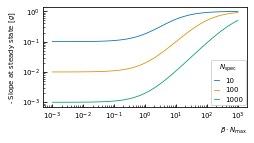

In [17]:
gpos = 1
KNmax = np.logspace(-3,3,100)
Nspec = 10

def speed_slope(gpos, KNmax, Nspec):
    return (gpos + KNmax)/(Nspec*gpos + KNmax)

def speed_slope2(gpos, K, Nmax, Nspec):
    steadystate = 1 / ( Nspec * gpos / Nmax + K)
    x = steadystate
    return - (1 - Nspec * (gpos / Nmax) * x - K * x - gpos / Nmax * x - K * x)

plt.figure(figsize=(KAOBOOK.TEXTWIDTH,2), tight_layout=True)

for Nspec in [10, 100, 1000]:
    plt.plot(KNmax, speed_slope(gpos, KNmax, Nspec), label = Nspec)
    
plt.legend(title=r'$N_\mathrm{spec}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\beta \cdot N_\mathrm{max}$', x=1, ha='right')
plt.ylabel('- Slope at steady state [$g$]')
plt.savefig('figures/speed.pdf')
plt.show()

## Intra-competition must be stronger than inter-competition for stability

Consider a system of gLV equations

\begin{equation}
\dot x = (g + A x) x
\end{equation}

The Jacobian of this equation is

\begin{equation}
J = \text{diag}(x^*) A
\end{equation}
where $x^*$ represents the steady state. For all species equivalent the Jacobian takes the shape

\begin{equation}
J = \begin{bmatrix} 
    d & o & \dots & o \\
    o & d & \dots & o \\
    \vdots & \vdots & \ddots & \vdots \\
    o & o & \dots & d\\ 
    \end{bmatrix}
\end{equation}

where the diagonal elements $d$ denote the self-interaction and the off-diagonal elements $o$ the interaction between species. The eigenvalues of this matrix are $d - o$ and $(N - 1)o + d$. When the interspecies competition is larger than the self-interaction, i.e. $d > o$ (since both values are negative), one of the eigenvalues becomes positive and therefore the system is unstable. A small perturbation of the steady state will result in one of the species taking over (winner-take-all).

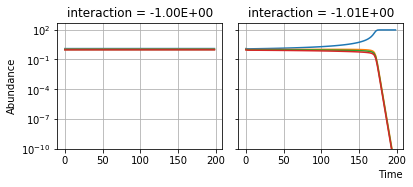

In [174]:
def rank_abundances_maximal_capacity_varying_maxima():
    N = 100

    params = {}

    steadystate = np.ones([N, 1])
    params['immigration_rate'] = np.zeros([N, 1])
    params['noise_linear'] = 0
    params['initial_condition'] = np.copy( steadystate) * np.random.normal(1, 0.1, steadystate.shape)

    ts = {}
    #ts2 = {}
    
    dt = 0.02
    tskip = 99
    T = 200.0

    mins = [1.0, 1.01] #[0.5, 1.0, 1.01, 1.05]

    for i in mins:
        omega = (-i) * np.ones([N, N])
        np.fill_diagonal(omega, -1)
        params['interaction_matrix'] = omega
        growth_rate =  - (omega).dot(steadystate)
        params['growth_rate'] = growth_rate
        params['maximum_capacity'] = growth_rate[0]/i
        
        ts['interaction = -%.2E' % i] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                              seed=int(time.time()), model=MODEL.GLV)
        #ts2['interaction = -%.2E' % i] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR_MAX, dt=dt, tskip=tskip, T=T,
        #                                      seed=int(time.time()), model=MODEL.GLV)

    return ts #, ts2

ts = rank_abundances_maximal_capacity_varying_maxima()
#print('Noise inside lattice')
p1 = PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])
plt.show()

#print('Noise outside lattice')
#p1, p2 = plot_function(ts2)
#p2.ax.set_ylim([1e-4, 1e0])
#plt.show()

## Noise spreads the rank abundance distribution

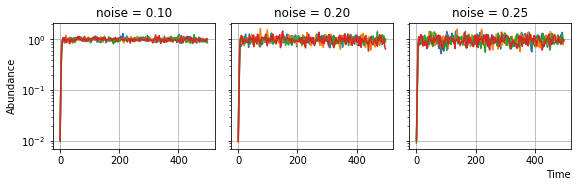

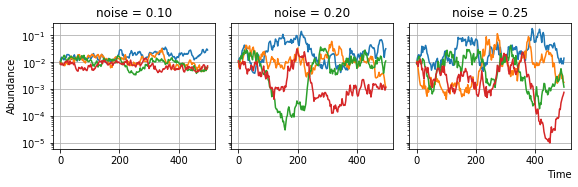

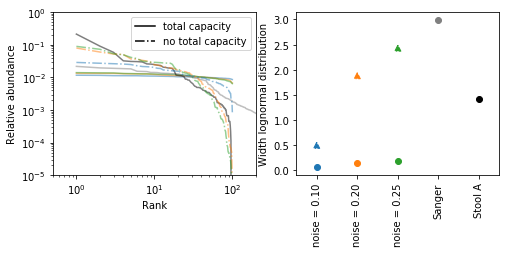

In [25]:
def rank_abundances_maximal_capacity_varying_noise():
    N = 100

    params = {}

    steadystate = np.ones([N,1])
    omega = np.zeros([N, N]);
    np.fill_diagonal(omega, -1)

    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    params['growth_rate'] = - (omega).dot(steadystate)
    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1, 0.1, steadystate.shape)
    
    ts = {}
    ts_mc = {}

    dt = 0.01
    tskip = 249
    T = 500.0

    noises = [0.1, 0.2, 0.25]
    
    max_cap = 0.01
    
    params_mc = params.copy()
    params_mc['maximum_capacity'] = max_cap * np.sum(steadystate)
    params_mc['initial_condition'] *= max_cap
    
    for i in noises:
        params['noise_linear'] = i
        params_mc['noise_linear'] = i
        
        ts['noise = %.2f' % i] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                      seed=int(time.time()), model=MODEL.GLV)

        ts_mc['noise = %.2f' % i] = glv.Timeseries(params_mc, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                seed=int(time.time()), model=MODEL.MAX)
    return ts, ts_mc

ts, ts_mc = rank_abundances_maximal_capacity_varying_noise()

PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])
PlotTimeseriesComparison([t.timeseries for label, t in ts_mc.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])

ax_ra, ax_s = plot_rankabundances(ts, with_experimental=True)

# reset color cycle
ax_ra.set_prop_cycle(None)
ax_s.set_prop_cycle(None)

plot_rankabundances(ts_mc, with_experimental=False, marker='^', linestyle='-.', ax_ra=ax_ra, ax_s=ax_s, raw=True)

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color='k'),
            Line2D([0], [0], color='k', linestyle='-.')]
labels = ['total capacity', 'no total capacity']
ax_ra.legend(handles, labels, ncol=1)

plt.show()

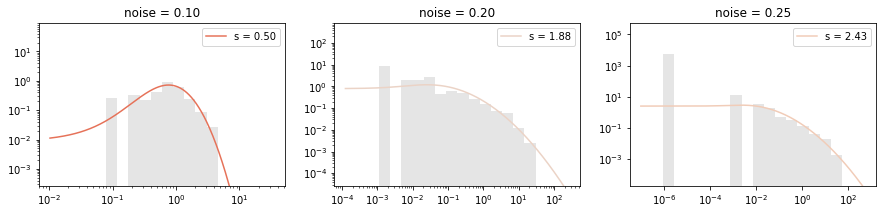

In [27]:
fig = plt.figure(figsize=(15,3))

for i, x in enumerate(ts, start=1):
    ax = fig.add_subplot(1, len(ts), i)
    ax.set_title(x)
    
    y = ts_mc[x].endpoint.to_numpy()
    fit_heavytail(y, ax=ax, func='lognorm', add_label=True)
    ax.set_yscale('log')
plt.savefig('figures_ra/noise_wider.pdf')
plt.show()

## Maximal capacity / noise

Both increasing the noise and decreasing the maximal capacity make the lognormal distribution wider. To obtain a width around 2 (grey values), we need a balanced combination of maximal capacity and noise. The smaller the maximal capacity, the less noise is needed to obtain a similar width.

T 100


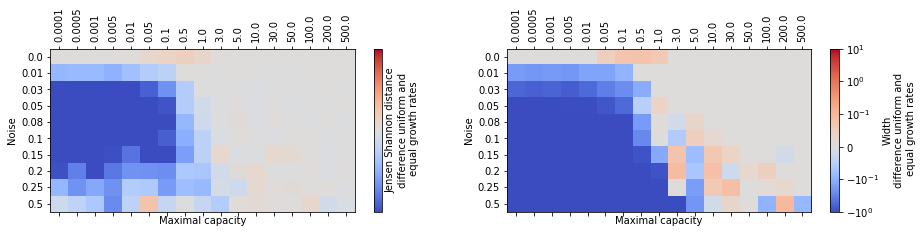

T 500


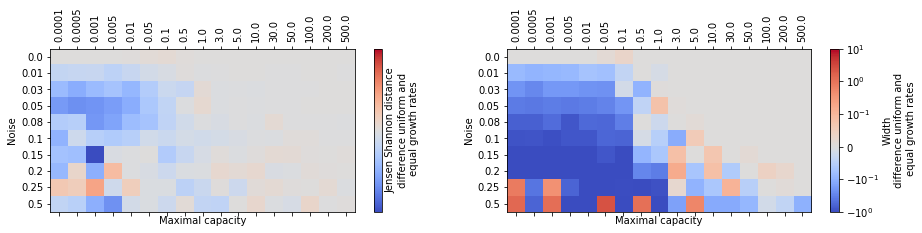

In [30]:
dfs = [df_JS, df_w]
labels = ['Jensen Shannon distance', 'Width']
norms = [None, norm_diffw]
bounds = [[-0.2, 0.2], [-10, 10]]
ticks = [[], [-1., -0.1, 0., 0.1, 1., 10.]]

Ts = [100, 500]

for T in Ts:
    print('T', T)
    
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 2)

    for i, df in enumerate(dfs):
        df1 = df_constraints(df, {'T': 900, 'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1,
                              'int_left' : 0, 'int_right' : 0, 
                                      'growth_rate_left' : 1, 'growth_rate_right' : 1})

        df1 = df1.pivot_table(values='median', index='noise', columns='max_cap')

        df2 = df_constraints(df, {'T': T, 'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1,
                              'int_left' : 0, 'int_right' : 0, 
                                      'growth_rate_left' : 1, 'growth_rate_right' : 1})
                             
        df2 = df2.pivot_table(values='median', index='noise', columns='max_cap')

        assert np.all(df1.index == df2.index) and np.all(df1.columns == df2.columns)
        
        diff = df2.to_numpy(dtype=float) - df1.to_numpy(dtype=float)

        ax = fig.add_subplot(gs[i])

        ax_mat = ax.matshow(diff, cmap='coolwarm',
                            vmin=bounds[i][0], vmax=bounds[i][1], 
                            aspect='auto', norm=norms[i])
        ax.set_xticks(range(len(df1.columns)))
        ax.set_xticklabels(df1.columns, rotation=90)
        ax.set_yticks(range(len(df1.index)))
        ax.set_yticklabels(df1.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        cbar = fig.colorbar(ax_mat, label=labels[i] +
                     '\n difference uniform and \n equal growth rates', ax=ax, ticks=ticks[i])

    plt.show()

We can consider two cases. In the first case, the maximal capacity effect is only implemented for the deterministic part. Here the total number of individuals can exceed the total capacity due to the noise term. In the second case, the maximal capacity effect is implemented for both the deterministic and stochastic part. This gives a bias to negative values for the noise term. There are small differences in the results for these two cases. When adding a maximal capacity to the noise term, the Jensen Shannon distance becomes a little smaller. Solutions get more predictable (less variance all same species?) The width of the lognormal distribution becomes also somewhat smaller, this means that the rank abundance curve becomes flatter.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in less


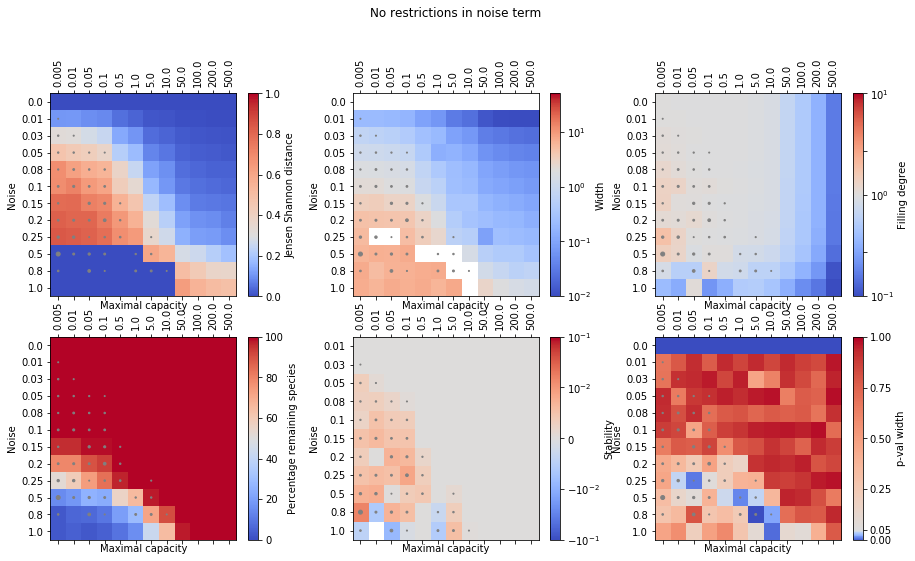

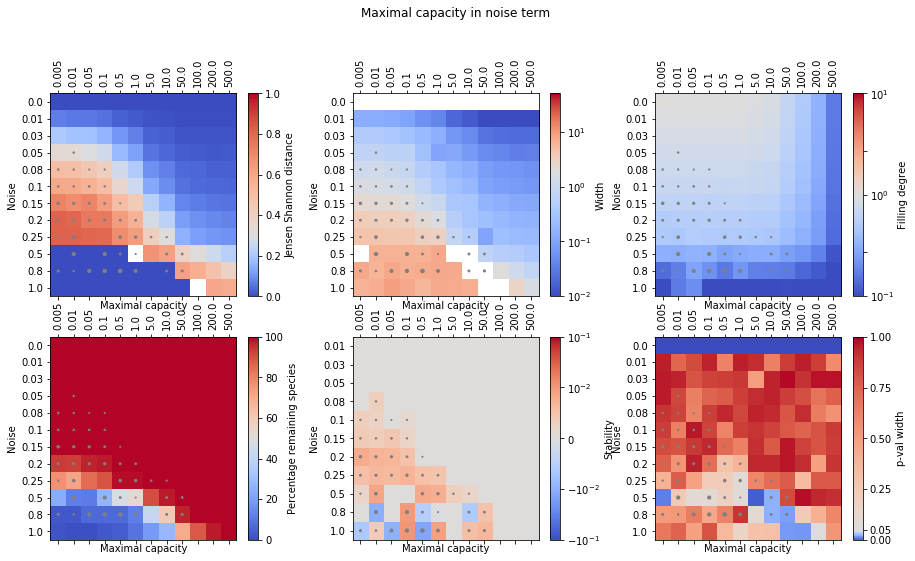

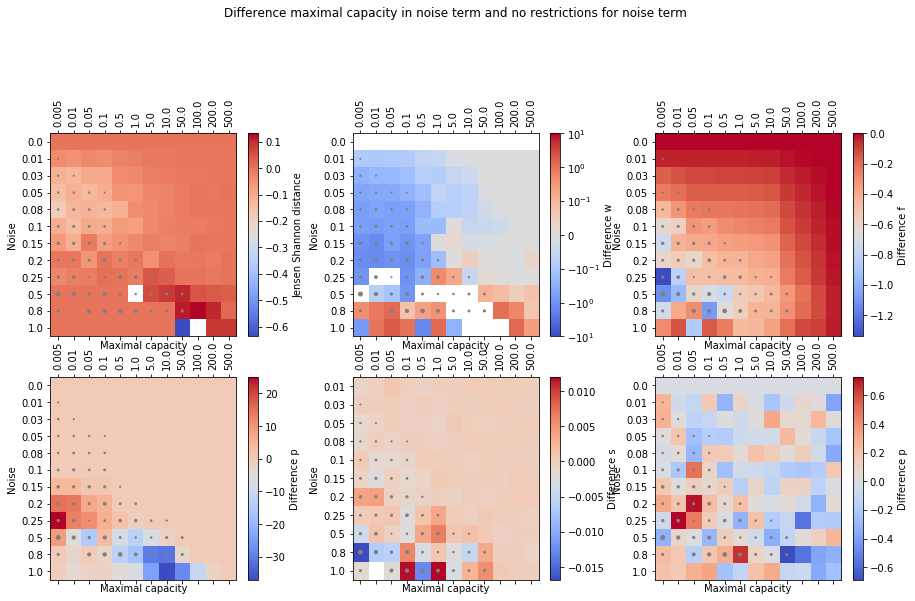

In [18]:
variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']

fig_1 = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, top=0.9, wspace=0.3) #1, len(dfs), top=0.8)
fig_1.suptitle('No restrictions in noise term', y=1.05)

fig_2 = plt.figure(figsize=(15, 8))
fig_2.suptitle('Maximal capacity in noise term', y=1.05)
#fig_2 = None

fig_comp = plt.figure(figsize=(15, 8))
fig_comp.suptitle('Difference maximal capacity in noise term and no restrictions for noise term', y=1.12)

constraints1 = {'noise_max': 0, 'self_int_left': -1, 'self_int_right': -1,
                                'int_left': 0, 'int_right': 0, 'growth_rate_left': 1, 'growth_rate_right': 1}
constraints2 = constraints1.copy(); constraints2['noise_max'] = 1;

stab1 = stability_mesh(constraints1)
stab2 = stability_mesh(constraints2)
stab_comp = np.maximum(stab1, stab2)

x, y = np.arange(stab1.shape[1]), np.arange(stab1.shape[0]); xv, yv = np.meshgrid(x, y)

for i, var in enumerate(variables):
    df_i1 = df_constraints(dfs[var], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
    df_i2 = df_constraints(dfs[var], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
    
    mat1 = df_i1.to_numpy(dtype=float)
    mat2 = df_i2.to_numpy(dtype=float)
    
    # remove values with low p-value
    if var is 'width':
        pvals1 = df_constraints(dfs['pval'], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
        pvals2 = df_constraints(dfs['pval'], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
        
        assert np.all(pvals1.columns == df_i1.columns) and np.all(pvals1.index == df_i1.index)
        assert np.all(pvals2.columns == df_i1.columns) and np.all(pvals2.index == df_i1.index)

        mat1[pvals1.to_numpy(dtype=float) < 0.05] = np.nan
        mat2[pvals2.to_numpy(dtype=float) < 0.05] = np.nan
   
    assert np.all(df_i1.columns == df_i2.columns) and np.all(df_i1.index == df_i2.index)
    mat_comp = mat2 - mat1
    
    for fig, mat, stab in zip([fig_1, fig_2, fig_comp], [mat1, mat2, mat_comp], [stab1, stab2, stab_comp]):
        if fig == None:
            continue;
        elif fig == fig_comp:
            var = 'diff_' + var;
            
        ax = fig.add_subplot(gs[i])

        ax_mat = ax.matshow(
            mat, cmap='coolwarm', norm=normalizations[var], aspect='auto',
            vmin=normalizations[var].vmin if normalizations[var] != None else None,
            vmax=normalizations[var].vmax if normalizations[var] != None else None)
        
        ax.scatter(xv, yv, s=stab, color='grey')
                        
        ax.set_xticks(range(len(df_i1.columns)))
        ax.set_xticklabels(df_i1.columns, rotation=90)
        ax.set_yticks(range(len(df_i1.index)))
        ax.set_yticklabels(df_i1.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        fig.colorbar(ax_mat, label=labels[var], ax=ax, ticks=ticks[var])    

#fig_1.savefig('figures_ra/grid.pdf')
#fig_comp.savefig('figures_ra/difference_noise_maximal_capacity.pdf')
plt.show()

In [ ]:
def plot_matshow(ax, var, constraints):
    dfi = df_constraints(dfs[var], constraints).pivot_table(values='median', index='noise', columns='max_cap')
    
    mat = dfi.to_numpy(dtype=float)
    
    # remove values with low p-value
    if var is 'width':
        pvals = df_constraints(dfs['pval'], constraints).pivot_table(values='median', index='noise', columns='max_cap')
        
        assert np.all(pvals.columns == dfi.columns) and np.all(pvals.index == dfi.index)
        
        mat[pvals.to_numpy(dtype=float) < 0.05] = np.nan
        
    assert np.all(dfi.columns == dfi.columns) and np.all(dfi.index == dfi.index)
     
    ax_mat = ax.matshow(
            mat, cmap='coolwarm', norm=normalizations[var], aspect='auto',
            vmin=normalizations[var].vmin if normalizations[var] != None else None,
            vmax=normalizations[var].vmax if normalizations[var] != None else None)
        
    ax.scatter(xv, yv, s=stab, color='grey')
                        
    ax.set_xticks(range(len(dfi.columns)))
    ax.set_xticklabels(dfi.columns, rotation=90)
    ax.set_yticks(range(len(dfi.index)))
    ax.set_yticklabels(dfi.index)
    ax.set_xlabel('Maximal capacity')
    ax.set_ylabel('Noise')
    fig.colorbar(ax_mat, label=labels[var], ax=ax, ticks=ticks[var])

def plot_matshow_comparison(ax, var, constraints1, constraints2):
    df1 = df_constraints(dfs[var], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
    df2 = df_constraints(dfs[var], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
    
    mat1 = df1.to_numpy(dtype=float)
    mat2 = df2.to_numpy(dtype=float)
    
    # remove values with low p-value
    if var is 'width':
        pvals1 = df_constraints(dfs['pval'], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
        pvals2 = df_constraints(dfs['pval'], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
        
        assert np.all(pvals1.columns == df1.columns) and np.all(pvals1.index == df1.index)
        assert np.all(pvals2.columns == df1.columns) and np.all(pvals2.index == df1.index)

        mat1[pvals1.to_numpy(dtype=float) < 0.05] = np.nan
        mat2[pvals2.to_numpy(dtype=float) < 0.05] = np.nan
   
    assert np.all(df1.columns == df2.columns) and np.all(df1.index == df2.index)
    mat_comp = mat2 - mat1
    
    ax_mat = ax.matshow(
            mat_comp, cmap='coolwarm', norm=normalizations[var], aspect='auto',
            vmin=normalizations[var].vmin if normalizations[var] != None else None,
            vmax=normalizations[var].vmax if normalizations[var] != None else None)
        
    ax.scatter(xv, yv, s=stab, color='grey')

    ax.set_xticks(range(len(df1.columns)))
    ax.set_xticklabels(df1.columns, rotation=90)
    ax.set_yticks(range(len(df1.index)))
    ax.set_yticklabels(df1.index)
    ax.set_xlabel('Maximal capacity')
    ax.set_ylabel('Noise')
    fig.colorbar(ax_mat, label=labels[var], ax=ax, ticks=ticks[var])

def complete_overview(title=):
    variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']
    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 3, top=0.9, wspace=0.3) #1, len(dfs), top=0.8)
    fig_1.suptitle('No restrictions in noise term', y=1.05)



In [ ]:
variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']

fig_1 = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, top=0.9, wspace=0.3) #1, len(dfs), top=0.8)
fig_1.suptitle('No restrictions in noise term', y=1.05)

fig_2 = plt.figure(figsize=(15, 8))
fig_2.suptitle('Maximal capacity in noise term', y=1.05)
#fig_2 = None

fig_comp = plt.figure(figsize=(15, 8))
fig_comp.suptitle('Difference maximal capacity in noise term and no restrictions for noise term', y=1.12)

constraints1 = {'noise_max': 0, 'self_int_left': -1, 'self_int_right': -1,
                                'int_left': 0, 'int_right': 0, 'growth_rate_left': 1, 'growth_rate_right': 1}
constraints2 = constraints1.copy(); constraints2['noise_max'] = 1;

stab1 = stability_mesh(constraints1)
stab2 = stability_mesh(constraints2)
stab_comp = np.maximum(stab1, stab2)

x, y = np.arange(stab1.shape[1]), np.arange(stab1.shape[0]); xv, yv = np.meshgrid(x, y)

for i, var in enumerate(variables):
    df_i1 = df_constraints(dfs[var], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
    df_i2 = df_constraints(dfs[var], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
    
    mat1 = df_i1.to_numpy(dtype=float)
    mat2 = df_i2.to_numpy(dtype=float)
    
    # remove values with low p-value
    if var is 'width':
        pvals1 = df_constraints(dfs['pval'], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
        pvals2 = df_constraints(dfs['pval'], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
        
        assert np.all(pvals1.columns == df_i1.columns) and np.all(pvals1.index == df_i1.index)
        assert np.all(pvals2.columns == df_i1.columns) and np.all(pvals2.index == df_i1.index)

        mat1[pvals1.to_numpy(dtype=float) < 0.05] = np.nan
        mat2[pvals2.to_numpy(dtype=float) < 0.05] = np.nan
   
    assert np.all(df_i1.columns == df_i2.columns) and np.all(df_i1.index == df_i2.index)
    mat_comp = mat2 - mat1
    
    for fig, mat, stab in zip([fig_1, fig_2, fig_comp], [mat1, mat2, mat_comp], [stab1, stab2, stab_comp]):
        if fig == None:
            continue;
        elif fig == fig_comp:
            var = 'diff_' + var;
            
        ax = fig.add_subplot(gs[i])

        ax_mat = ax.matshow(
            mat, cmap='coolwarm', norm=normalizations[var], aspect='auto',
            vmin=normalizations[var].vmin if normalizations[var] != None else None,
            vmax=normalizations[var].vmax if normalizations[var] != None else None)
        
        ax.scatter(xv, yv, s=stab, color='grey')
                        
        ax.set_xticks(range(len(df_i1.columns)))
        ax.set_xticklabels(df_i1.columns, rotation=90)
        ax.set_yticks(range(len(df_i1.index)))
        ax.set_yticklabels(df_i1.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        fig.colorbar(ax_mat, label=labels[var], ax=ax, ticks=ticks[var])    

#fig_1.savefig('figures_ra/grid.pdf')
#fig_comp.savefig('figures_ra/difference_noise_maximal_capacity.pdf')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


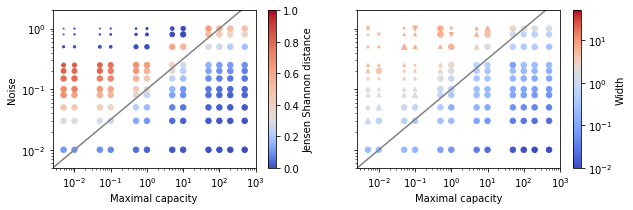

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [58]:
def plot_in_loglog(ax, var, constraints):
    df = df_constraints(dfs[var], constraints).pivot_table(values='median', index='noise', columns='max_cap', dropna=False)
    mat = df.to_numpy(dtype=float)
    
    if var == 'width':
        stab = df_constraints(dfs['stability'], constraints1).pivot_table(values='median', index='noise', columns='max_cap', dropna=False)

        assert np.all(stab.columns == df.columns) and np.all(stab.index == df.index)

        th = 1e-3 #threshold of slope for stability
        markers = np.full_like(mat, '', dtype=str); 
        markersize = np.full_like(mat, 0);

        markers[np.abs(stab1) < th] = 'o';
        markers[stab1 < -th] = 'v'; markers[stab1 > th] = '^'; 

        markersize = th*30/np.abs(stab1); # 100 good size of marker
        markersize = np.clip(markersize, a_min=0, a_max=30)
    elif var == 'JS':
        number = df_constraints(dfs['number'], constraints1).pivot_table(values='median', index='noise', columns='max_cap', dropna=False)

        assert np.all(number.columns == df.columns) and np.all(number.index == df.index)

        markers = np.full_like(mat, 'o', dtype=str); 
        
        markersize = number/100*30; # 30 good size of marker
        markersize = np.clip(markersize, a_min=0, a_max=30)
    else:
        markers = np.full_like(mat, 'o', dtype=str); 
        markersize = np.full_like(mat, 30);
        
    x = df.columns # maximal capacity
    y = df.index # noise
    xx = np.logspace(np.log10(0.5*min(x)), np.log10(2*max(x)), 100)

    xv, yv = np.meshgrid(x, y)
    #yv = yv / xv # (1/xv + 1)
    
    for m in np.unique(markers):
        s = np.ma.masked_where(markers != m, markersize)
        ax_sc = ax.scatter(xv, yv, c=mat, norm=normalizations[var], cmap='coolwarm', marker=m, s=s)
    
    ax.plot(xx, (xx/100)**(1/2), color='grey')
    #for i in [100]: #[1, 10, 100]:o
        #ax.plot(xx, 1/(i/xx + 1))
        #ax.plot(xx, np.abs(1/(xx/i-1)))
        #ax.plot(xx, np.sqrt(xx))

    ax.set_xlabel('Maximal capacity')
    ax.set_ylabel('Noise')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlim([0.5*min(x), 2*max(x)])
    ax.set_ylim([5e-3, 2])

    plt.colorbar(ax_sc, label=labels[var], ax=ax, ticks=ticks[var])    

fig = plt.figure(figsize=(10, 3), tight_layout=True)
gs = gridspec.GridSpec(1, 2, wspace=0.2, bottom=0.15)

constraints = {'noise_max': 0, 'self_int_left': -1, 'self_int_right': -1,
                                'int_left': 0, 'int_right': 0, 'growth_rate_left': 1, 'growth_rate_right': 1}

for i, gsi, var in zip(count(), gs, ['JS', 'width']): #, 'filling']):
    ax = fig.add_subplot(gsi, sharey=ax if i>0 else None)
    plot_in_loglog(ax, var, constraints)
    
    if i > 0:
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)

plt.show()
#fig.savefig('figures_ra/grid2.pdf')
#fig_comp.savefig('figures_ra/difference_noise_maximal_capacity.pdf')
    

The p-values are high. This means that the distributions show a good fit to a lognormal distribution and that the value for the width can be used as a parameter. Low p-values and therefore bad fits to  lognormal distributions are found in the absence of noise and higher maximal capacities and high noise values and small maximal capacities. These parameter regions can be excluded because they are not compatible with the lognormal distributions we observe for experimental data. Because of the badness of the fit, the values of width are useless.

No restrictions in noise term


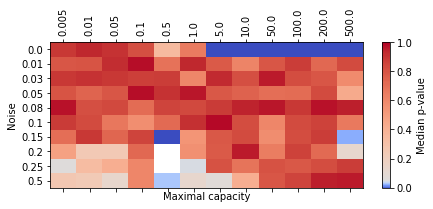

In [26]:
for noise_max, message in zip([0], #1], 
                              ['No restrictions in noise term']): #, 'Maximal capacity in noise term']):
    print(message)

    values = ['median'] #['min', 'median']
    labels = ['Median p-value'] #['Min p-value', 'Median p-value']

    fig = plt.figure(figsize=(7,3))
    gs = gridspec.GridSpec(1, len(values), top=0.8)

    for i, value, label in zip(count(), values, labels):
        df_i = df_constraints(dfs['pval'], {'noise_max' : noise_max, 'self_int_left' : -1., 'self_int_right' : -1.,
                                  'int_left' : 0., 'int_right' : 0., 'growth_rate_left' : 1., 'growth_rate_right' : 1.,
                                    }
                            ).pivot_table(values=value, index='noise', columns='max_cap')
        ax = fig.add_subplot(gs[i])

        ax_mat = ax.matshow(df_i.to_numpy(dtype=float), cmap='coolwarm', norm=norm_p, vmin=0, vmax=1, aspect='auto')
        ax.set_xticks(range(len(df_i.columns)))
        ax.set_xticklabels(df_i.columns, rotation=90)
        ax.set_yticks(range(len(df_i.index)))
        ax.set_yticklabels(df_i.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        fig.colorbar(ax_mat, label=label, ax=ax)
    #plt.savefig('figures_ra/pvalues.pdf')
    plt.show()

Why are p-values good / bad? Details of fit see notebook : Goodness fit heavy-tailed distributions

In [27]:
print('Noise : 0.08, maximal capacity : 1.0')

con = {'noise_max' : 0, 'max_cap':1., 'self_int_left' : -1, 'self_int_right' : -1,
'int_left' : 0, 'int_right' : 0, 'growth_rate_left' : 1, 'growth_rate_right' : 1, 'noise': 0.08}

plot_distributions(con)

print('Noise : 0.5, maximal capacity : 0.01')

con = {'noise_max' : 0, 'max_cap':0.01, 'self_int_left' : -1, 'self_int_right' : -1,
'int_left' : 0, 'int_right' : 0, 'growth_rate_left' : 1, 'growth_rate_right' : 1, 'noise': 0.5}

plot_distributions(con)

Noise : 0.08, maximal capacity : 1.0


FileNotFoundError: [Errno 2] File rankabundance/results_p1.csv does not exist: 'rankabundance/results_p1.csv'

## For all species equivalent the steady state depends on initial conditions

Because all species are equivalent in the deterministic model, the differences in abundance are created by the noise. The Jensen Shannon distance between the endpoints of different simulations with the same parameters are arount 0.8. The median JS distance between time points of the same time series is around 0.7.

NameError: name 'ax_s' is not defined

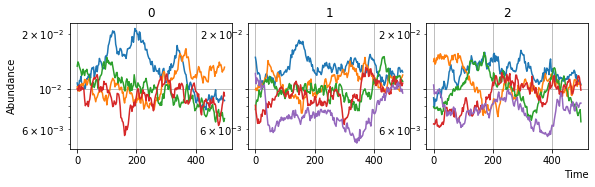

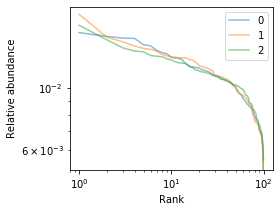

In [53]:
def rank_abundances_maximal_capacity_varying_initial_conditions1():
    N = 100

    params = {}

    steadystate = np.ones([N,1])
    omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)
    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    params['growth_rate'] = - (omega).dot(steadystate)
    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1, 0.1, steadystate.shape)
    params['noise_linear'] = 3e-2

    ts = {}

    dt = 0.01
    tskip = 249
    T = 500.0

    no_max = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                      seed=int(time.time()), model=MODEL.GLV)

    labels = np.arange(3)

    for i in labels:
        params['maximum_capacity'] = 0.01 * sum(no_max.endpoint.values)
        params['initial_condition'] = np.copy(
            steadystate) * np.random.normal(0.01, 0.003, steadystate.shape)

        ts[i] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                               seed=int(time.time()), model=MODEL.MAX)
    return ts

ts = rank_abundances_maximal_capacity_varying_initial_conditions1()
p1 = PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])

p2 = plot_rankabundances(ts, with_experimental=False)

species = ts[0].endpoint.rank(ascending=False).sort_values(by='endpoint').index.tolist()[:3]
p2.identify_rank_species(species)

for i in combinations(ts.keys(), 2):
    print("The Jensen Shannon distance between the endpoints of timeseries " + str(i[0]) + " and " + str(i[1]) +
          " is %.2f." % JensenShannon(ts[i[0]].endpoint.to_numpy().flatten() + 1e-10, 
                                      ts[i[1]].endpoint.to_numpy().flatten() + 1e-10))
    # 1e-10 is pseudocount because JS distance not defined when there are zeros in data
    

fig = plt.figure(figsize=(11,3))

for i, key in enumerate(ts.keys(), start=1):
    ax = fig.add_subplot(1, len(ts.keys()), i, sharey=ax if i>1 else None)
    ax.set_title('timeseries %d' % i)
    
    tsi = ts[key].timeseries; 
    tsi = tsi[[col for col in tsi.columns if col.startswith('species')]].values

    c = list(combinations(range(len(tsi)),2))
    np.random.shuffle(c)

    N = 1000

    JS = np.zeros(N)

    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(tsi[comb[0]] + 1e-10, tsi[comb[1]] + 1e-10)

    ax.hist(JS, bins=np.linspace(0,1,20), density=True)
    ax.set_xlim([0,1])
    ax.axvline(x=np.median(JS), label='median', color='red', linestyle=':')
        
    if i == len(ts.keys()):
        ax.set_xlabel("Jensen Shannon distance", ha='right', x=1)
        ax.legend()
    if i == 1:
        ax.set_ylabel("Frequency")
plt.show()

We thus need to change the model. We try whether individual parameters for all species makes the time series more reproducible and if this decreases the JS distance. 

# Influence other parameters

## Growth rates

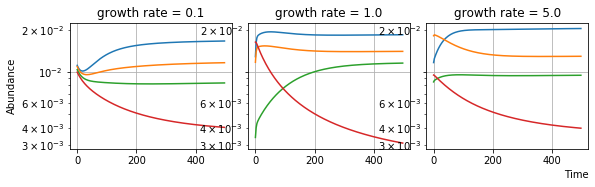

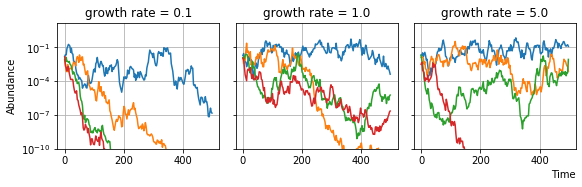

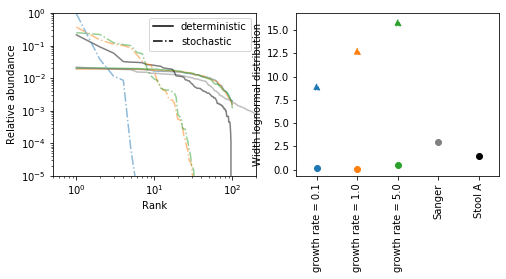

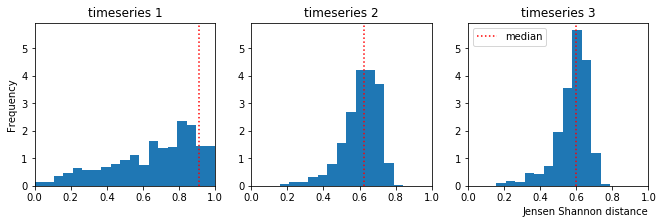

In [196]:
def rank_abundances_maximal_capacity_varying_growth_rate():
    params = {}

    N = 100

    steadystate = np.ones([N, 1])
    omega = np.zeros([N, N])
    np.fill_diagonal(omega, -1)
    params['interaction_matrix'] = omega
    params['immigration_rate'] = np.zeros([N, 1])
    params['initial_condition'] = np.copy(
        steadystate) * np.random.normal(1, 0.1, steadystate.shape)
    max_cap = 0.01
    params['maximum_capacity'] = max_cap * sum(steadystate)
    params['initial_condition'] = max_cap * np.copy(
        steadystate) * np.random.normal(1, 0.1, steadystate.shape)

    ts = {}
    ts_nonoise = {}

    dt = 0.01
    tskip = 249
    T = 500.0

    growth_rate = [0.1, 1, 5]

    for g in growth_rate:
        params['growth_rate'] = np.random.uniform(0, g, [N, 1])

        params['noise_linear'] = 0
        ts_nonoise['growth rate = %.1f' % g] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                              seed=int(time.time()), model=MODEL.MAX)
        
        params['initial_condition'] = ts_nonoise['growth rate = %.1f' % g].endpoint
        params['noise_linear'] = 0.2
        ts['growth rate = %.1f' % g] = glv.Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR, dt=dt, tskip=tskip, T=T,
                                                      seed=int(time.time()), model=MODEL.MAX)
    return ts_nonoise, ts

#ts_nonoise, ts = rank_abundances_maximal_capacity_varying_growth_rate()

PlotTimeseriesComparison([t.timeseries for label, t in ts_nonoise.items()], 
                             composition=['ts'], titles=[label for label, t in ts_nonoise.items()])
PlotTimeseriesComparison([t.timeseries for label, t in ts.items()], 
                             composition=['ts'], titles=[label for label, t in ts.items()])

#fig = plt.figure()
#ax = fig.add_subplot(111)
#PlotRankAbundance(experimental_ra, labels='experimental', ax=ax)

colors = PlotRankAbundance.COLORS

if False:
    for i, label in enumerate(ts.keys()):
        ra = ts[label].endpoint
        ra_nn = ts_nonoise[label].endpoint
        #ra2 = ts[label].timeseries.iloc[250].drop('time')

        PlotRankAbundance(ra_nn, ax=ax, color=colors[i], linestyle='-.')
        PlotRankAbundance(ra, ax=ax, color=colors[i], labels=label)
        #PlotRankAbundance(ra2, ax=ax, color=colors[i], labels=label + 'hw')
    ax.set_ylim([1e-4, 1e0])
    #ax.legend()

ax_ra, ax_s = plot_rankabundances(ts_nonoise, with_experimental=True)

# reset color cycle
ax_ra.set_prop_cycle(None)
ax_s.set_prop_cycle(None)

plot_rankabundances(ts, with_experimental=False, marker='^', linestyle='-.', ax_ra=ax_ra, ax_s=ax_s, raw=True)

#handles, labels = ax_ra.get_legend_handles_labels()
handles = [Line2D([0], [0], color='k'),
            Line2D([0], [0], color='k', linestyle='-.')]
labels = ['deterministic', 'stochastic']
ax_ra.legend(handles, labels, ncol=1)

#plt.savefig('figures/rank_abundance/importance_growth_rate.png')

fig = plt.figure(figsize=(11,3))

for i, key in enumerate(ts.keys(), start=1):
    ax = fig.add_subplot(1, len(ts.keys()), i, sharey=ax if i>1 else None)
    ax.set_title('timeseries %d' % i)
    
    tsi = ts[key].timeseries; 
    tsi = tsi[[col for col in tsi.columns if col.startswith('species')]].values

    c = list(combinations(range(len(tsi)),2))
    np.random.shuffle(c)

    N = 1000

    JS = np.zeros(N)

    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(tsi[comb[0]] + 1e-10, tsi[comb[1]] + 1e-10)

    ax.hist(JS, bins=np.linspace(0,1,20), density=True)
    ax.set_xlim([0,1])
    ax.axvline(x=np.median(JS), label='median', color='red', linestyle=':')
        
    if i == len(ts.keys()):
        ax.set_xlabel("Jensen Shannon distance", ha='right', x=1)
        ax.legend()
    if i == 1:
        ax.set_ylabel("Frequency")
plt.show()

todo check difference definition distance / divergence (sqrt difference)

Jensen Shannon distance is scale independent. The Jensen Shannon distance is defined as
\begin{equation}
    JS(x_1, x_2) = \sqrt{ \frac{1}{2} \left( KL(x_1, (x_1 + x_2)/2) + KL(x_2, (x_1 + x_2)/2) \right) }
\end{equation}
where $KL$ is the Kullback Leibler distance.
The latter is defined as
\begin{equation}
KL(x_1, x_2) = \sum_i{ \frac{x_{1,i}}{\sum_j x_{1,j}} \ln{\frac{x_{1,i} \sum_j x_{2,j}}{x_{2,i} \sum_j x_{1,j}}} }
\end{equation}
Because in the definition of the Kullback Leibler distance only the relative frequencies are considered ($x_i / \sum_j x_j$), the Kullback Leibler distance and therefore also the Jensen Shannon distance is scale invariant.

We can check the Jensen Shannon distance between 2 simulations with the same parameters where the endpoints will be different because of the random noise. By checking this distance between 2 simulations, we can verify how predictable the outcome is with respect to the input parameters and how robust the steady state is to noise. In experimental data the distance is around 0.3. 

We see that decreasing the maximal capacity increases the JS distance. As expected increasing the noise also increases the JS distance. The use of different growth rates has only a minor effect (?). 

Growth rate bounds [1, 1]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in less


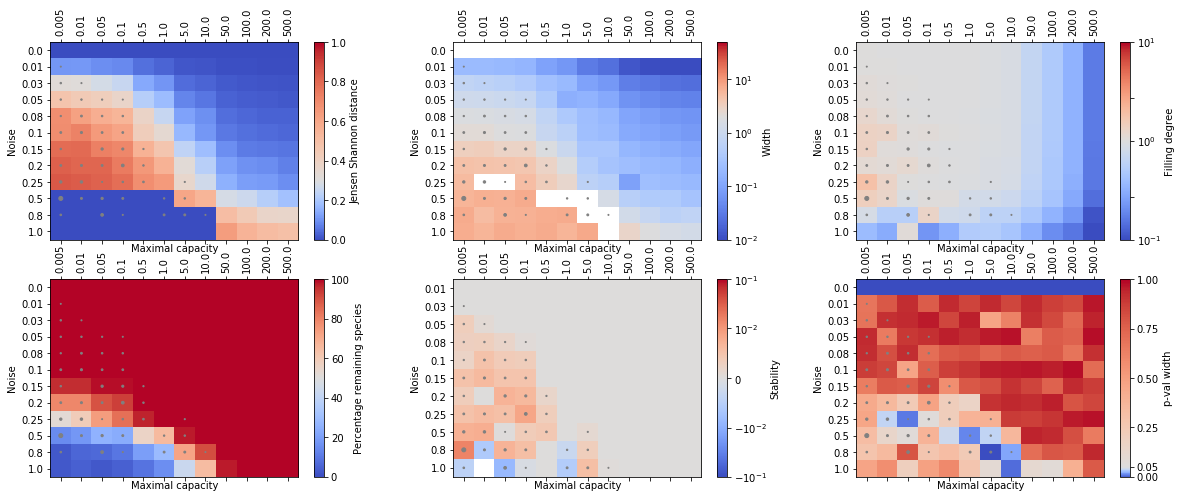

Growth rate bounds [0, 1]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


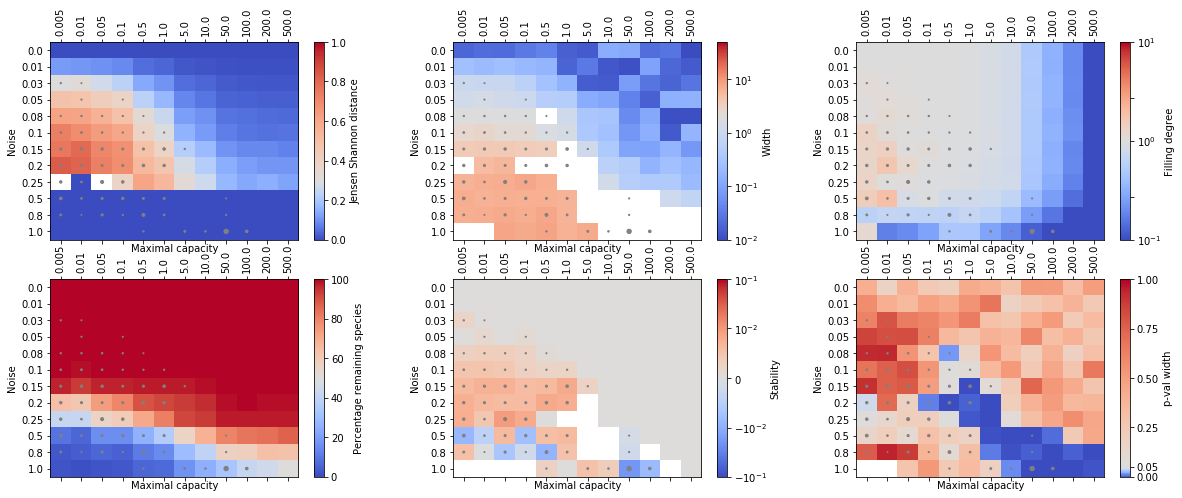

Growth rate bounds [0, 10]


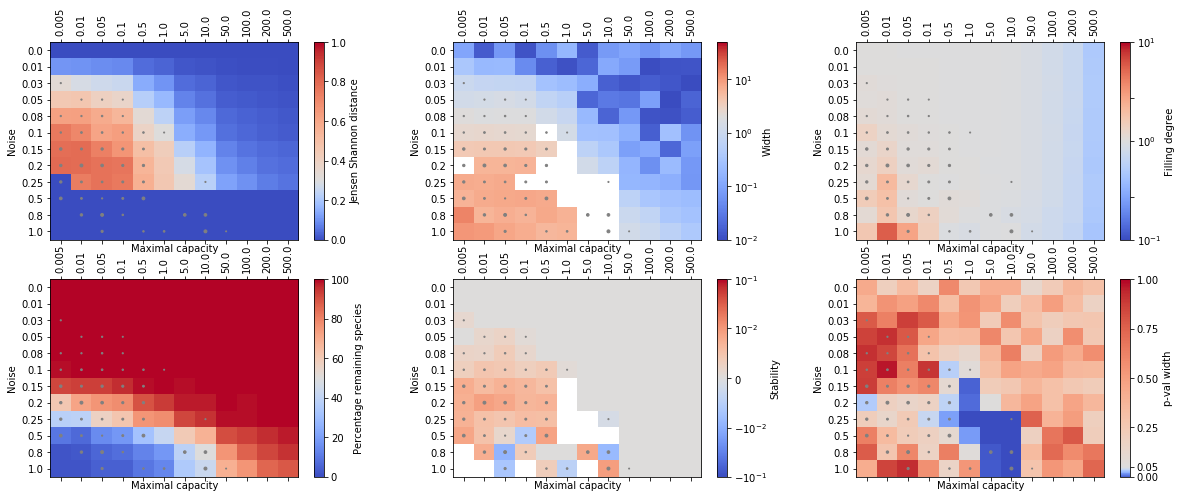

In [19]:
variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']

growth_rate_bounds = [[1,1], [0,1], [0,10]]
for growth_rate_bound in growth_rate_bounds:
    print('Growth rate bounds', growth_rate_bound)
    
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(2, 3, wspace=0.3)
    
    constraints = {'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1, 'int_left' : 0, 'int_right' : 0, 
                   'growth_rate_left' : growth_rate_bound[0], 'growth_rate_right' : growth_rate_bound[1]}
    
    stab = stability_mesh(constraints)
    
    x, y = np.arange(stab.shape[1]), np.arange(stab.shape[0]); xv, yv = np.meshgrid(x, y)

    for i, var in enumerate(variables):
        df_i = df_constraints(dfs[var], constraints).pivot_table(values='median', index='noise', columns='max_cap')
                                     
        mat = df_i.to_numpy(dtype=float)
    
        # remove values with low p-value
        if var is 'width':
            pvals = df_constraints(dfs['pval'], constraints)
            p = pvals.pivot_table(values='median', index='noise', columns='max_cap')
            assert np.all(df_i.columns == p.columns) and np.all(df_i.index == p.index)
            
            mat[p.to_numpy(dtype=float) < 0.05] = np.nan

        ax = fig.add_subplot(gs[i])
        
        ax_mat = ax.matshow(mat, cmap='coolwarm', norm=normalizations[var], aspect='auto',
                vmin=normalizations[var].vmin if normalizations[var] != None else None,
                vmax=normalizations[var].vmax if normalizations[var] != None else None)
        
        ax.scatter(xv, yv, s=stab, color='grey')
        
        ax.set_xticks(range(len(df_i.columns)))
        ax.set_xticklabels(df_i.columns, rotation=90)
        ax.set_yticks(range(len(df_i.index)))
        ax.set_yticklabels(df_i.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        fig.colorbar(ax_mat, label=labels[var], ax=ax, ticks=ticks[var])
    plt.show()

Look at the difference. We expect that for larger noise, different sets of parameters will help the system to remain closer to steady state. This is what we see but only for higher maximal capacities (blue region). No real difference.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


Growth rate bounds [0, 1]


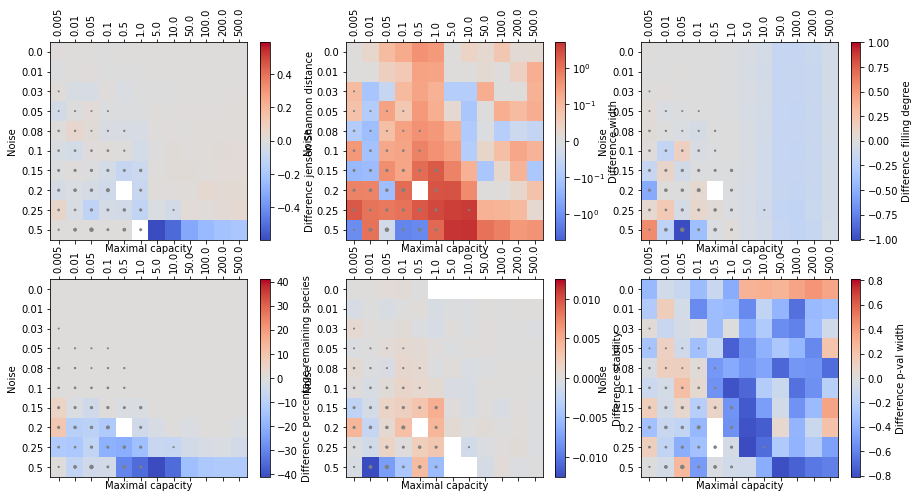

Growth rate bounds [0, 10]


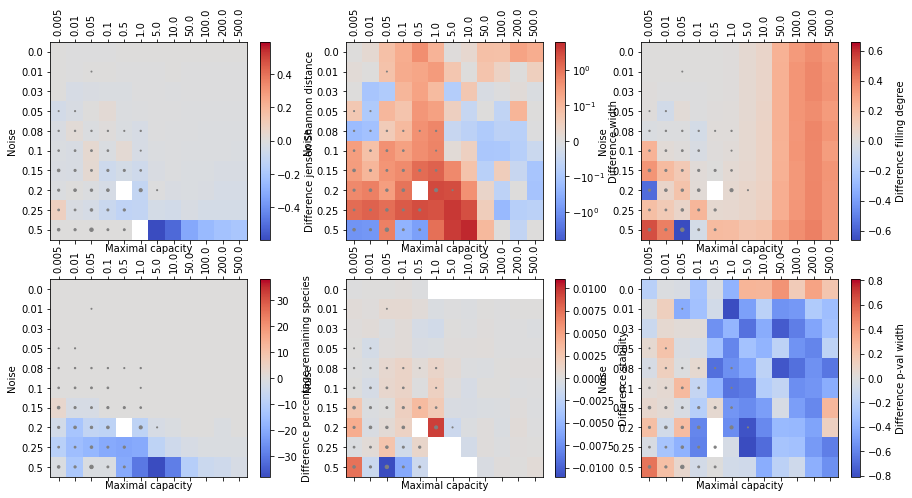

In [25]:
variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']

constraints1 = {'noise_max': 0, 'self_int_left': -1, 'self_int_right': -1, 'int_left': 0., 'int_right': 0., 'growth_rate_left': 1, 'growth_rate_right': 1}
stab1 = stability_mesh(constraints1)

x, y = np.arange(stab1.shape[1]), np.arange(stab1.shape[0]); xv, yv = np.meshgrid(x, y)

growth_rate_bounds = [[0,1], [0,10]]
for growth_rate_bound in growth_rate_bounds:
    print('Growth rate bounds', growth_rate_bound)
    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 3)
    
    constraints2 = {'noise_max': 0, 'self_int_left': -1, 'self_int_right': -1, 'int_left': 0., 'int_right': 0.,
                    'growth_rate_left': growth_rate_bound[0], 'growth_rate_right': growth_rate_bound[1]}
    
    stab2 = stability_mesh(constraints2)
    stab_comp = np.maximum(stab1, stab2)

    for i, var in enumerate(variables):
        df1 = df_constraints(dfs[var], constraints1)

        df1 = df1.pivot_table(values='median', index='noise', columns='max_cap')

        df2 = df_constraints(dfs[var], constraints2)

        df2 = df2.pivot_table(values='median', index='noise', columns='max_cap')

        assert np.all(df1.index == df2.index) and np.all(df1.columns == df2.columns)
        
        diff = df2.to_numpy(dtype=float) - df1.to_numpy(dtype=float)

        ax = fig.add_subplot(gs[i])
        
        # symmetric colorscheme
        vmin, vmax = np.nanmin(diff), np.nanmax(diff)
        vmin = min(vmin, -vmax); vmax = -vmin
        
        ax_mat = ax.matshow(diff, cmap='coolwarm', aspect='auto', norm=normalizations['diff_'+var],
                            vmin=vmin, vmax=vmax)
        ax.scatter(xv, yv, s=stab_comp, color='grey')
        
        ax.set_xticks(range(len(df1.columns)))
        ax.set_xticklabels(df1.columns, rotation=90)
        ax.set_yticks(range(len(df1.index)))
        ax.set_yticklabels(df1.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Noise')
        cbar = fig.colorbar(ax_mat, label=labels['diff_'+var], ax=ax, ticks=ticks['diff_'+var])
    
    #if growth_rate_bound[1] == 10:
    #    plt.savefig('figures_ra/difference_growth_rate.pdf')
    plt.show()

Noise : 0.1, maximal capacity : 10.0, growth rate : 1
Noise : 0.1, maximal capacity : 10.0, growth rate : [0-10]


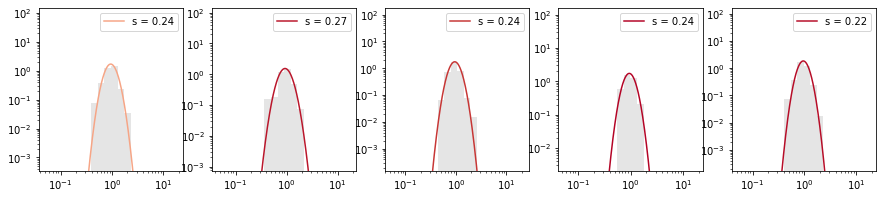

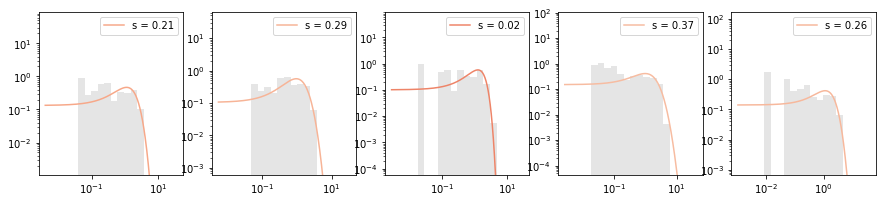

In [51]:
print('Noise : 0.1, maximal capacity : 10.0, growth rate : 1')

con = {'noise_max' : 0, 'max_cap': 10.0, 'self_int_left' : -1, 'self_int_right' : -1,
'int_left' : 0, 'int_right' : 0, 'growth_rate_left' : 1, 'growth_rate_right' : 1, 'noise': 0.1}

plot_distributions(con)

print('Noise : 0.1, maximal capacity : 10.0, growth rate : [0-10]')

con = {'noise_max' : 0, 'max_cap': 10.0, 'self_int_left' : -1, 'self_int_right' : -1,
'int_left' : 0, 'int_right' : 0, 'growth_rate_left' : 0, 'growth_rate_right' : 10, 'noise': 0.1}

plot_distributions(con)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


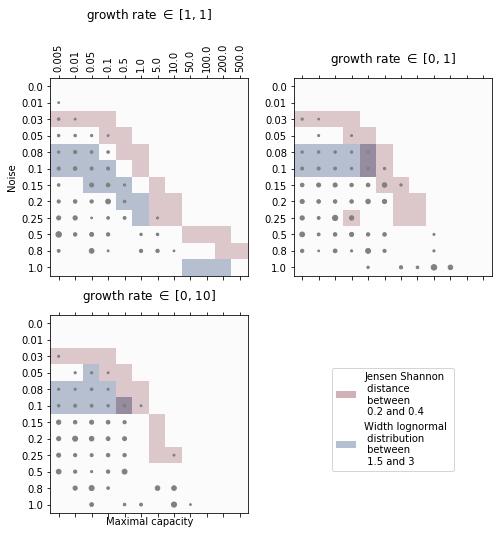

In [42]:
growth_rate_bounds = [[1,1], [0,1], [0,10]]
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 2) #, right=0.7)
gs_legend = gridspec.GridSpec(1, 1, left=0.55, top=0.45)

for i, growth_rate_bound in enumerate(growth_rate_bounds):
    ax = fig.add_subplot(gs[i], sharex=ax if i>0 else None)
    if i == 0:
        ax.text(0.5, 1.3, 'growth rate $\in$ [%.d, %.d]' % tuple(growth_rate_bound), 
                horizontalalignment='center', fontsize=12, transform = ax.transAxes)
    else:
        ax.set_title('growth rate $\in$ [%.d, %.d]' % tuple(growth_rate_bound))
    
    constraints = {'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1, 'int_left' : 0, 'int_right' : 0, 
                'growth_rate_left' : growth_rate_bound[0], 'growth_rate_right' : growth_rate_bound[1]}
    
    mat_JS = df_constraints(dfs['JS'], constraints).pivot_table(values='median', index='noise', columns='max_cap')
        
    mat_w = df_constraints(dfs['width'], constraints).pivot_table(values='median', index='noise', columns='max_cap')
    
    stab = stability_mesh(constraints)
    x, y = np.arange(stab.shape[1]), np.arange(stab.shape[0]); xv, yv = np.meshgrid(x, y)

    assert np.all(mat_JS.index == mat_w.index)
    assert np.all(mat_JS.columns == mat_w.columns)

    JS_mask = (0.2 < mat_JS.to_numpy()) & (mat_JS.to_numpy() < 0.4)

    w_mask = (1.5 < mat_w.to_numpy()) & (mat_w.to_numpy() < 3)

    ax.matshow(JS_mask, alpha=0.3, cmap='Reds')
    ax.matshow(w_mask, alpha=0.3, cmap='Blues')
    ax.scatter(xv, yv, s=stab, color='grey')
    
    ax.set_xticks(range(len(mat_JS.columns)))
    if i == 0:
        ax.set_xticklabels(mat_JS.columns, rotation=90)
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_yticks(range(len(mat_JS.index)))
    ax.set_yticklabels(mat_JS.index)
    
    if i == len(growth_rate_bounds)-1:
        ax.set_xlabel('Maximal capacity')
    if i == 0 or (len(growth_rate_bounds) == 0 and i == 1):
        ax.set_ylabel('Noise')
        
ax = fig.add_subplot(gs_legend[0], frameon=False)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

handles = [ Patch(facecolor=plt.cm.get_cmap('Reds')(1.), alpha=0.3, label='Jensen Shannon \n distance \n between \n 0.2 and 0.4'),
            Patch(facecolor=plt.cm.get_cmap('Blues')(1.), alpha=0.3, label='Width lognormal \n distribution \n between \n 1.5 and 3')]

ax.legend(handles=handles, loc='center')

#plt.savefig('figures_ra/overlap.pdf')
plt.show()

The value / distribution of the self-interaction has little influence on the JS distance.

## Self-interaction

Self interaction bounds [-0.1, -5]


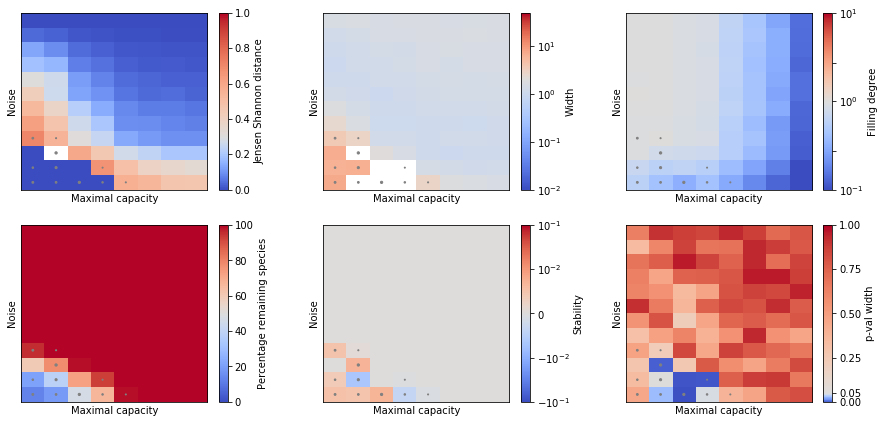

<Figure size 1080x576 with 0 Axes>

In [23]:
variables = ['JS', 'width', 'filling', 'number', 'stability', 'pval']

filenames = ['figures_ra/difference_self_int_5.pdf', 'figures_ra/difference_self_int_10.pdf']

constraints1 = {'noise_max': 0, 'self_int_left': -1., 'self_int_right': -1.,
                                  'int_left': 0., 'int_right': 0.,
                                  'growth_rate_left': 1, 'growth_rate_right': 1}

stab1 = stability_mesh(constraints1)

self_int_bounds = [[-0.1, -5]] #[[-5, -5], [-0.1, -5]]
for self_int_bound, filename in zip(self_int_bounds, filenames):
    print('Self interaction bounds', self_int_bound)
    
    fig = plt.figure(figsize=(15, 8))
    fig_diff = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 3, top=0.8, wspace=0.3)
    
    constraints2 = constraints1.copy();
    constraints2['self_int_left'] = self_int_bound[0]; constraints2['self_int_right'] = self_int_bound[1];
    
    stab2 = stability_mesh(constraints2)
    #stab_comp = np.maximum(stab1, stab2)
        
    for i, var in enumerate( variables):
        #df1 = df_constraints(dfs[var], constraints1)
        #df1 = df1.pivot_table(values='median', index='noise', columns='max_cap')

        df2 = df_constraints(dfs[var], constraints2)
        df2 = df2.pivot_table(values='median', index='noise', columns='max_cap')
        
        #assert np.all(df1.index == df2.index) and np.all(df1.columns == df2.columns)
        
        #diff = df2.to_numpy(dtype=float) - df1.to_numpy(dtype=float)
        
        
        if var is 'width':
            #pvals1 = df_constraints(dfs['pval'], constraints1).pivot_table(values='median', index='noise', columns='max_cap')
            pvals2 = df_constraints(dfs['pval'], constraints2).pivot_table(values='median', index='noise', columns='max_cap')
            
            #assert np.all(df1.index == pvals1.index) and np.all(df1.columns == pvals1.columns)
            #assert np.all(df1.index == pvals2.index) and np.all(df1.columns == pvals2.columns)
            
            df2[pvals2.to_numpy(dtype=float) < 0.05] = np.nan
            
            #for pvals in [pvals1, pvals2]:
            #    diff[pvals.to_numpy(dtype=float) < 0.05] = np.nan
                
        #for f, df, stab, v in zip([fig, fig_diff], [df2, diff], [stab2, stab_comp], [var, 'diff_'+var]):
        for f, df, stab, v in zip([fig], [df2], [stab2], [var]):
            ax = f.add_subplot(gs[i])
            
            if len(df) > 0:
                if normalizations[v] == None:
                    # symmetric colorscheme
                    vmin, vmax = np.nanmin(df), np.nanmax(df)
                    vmin = min(vmin, -vmax); vmax = -vmin
                else:
                    vmin, vmax = normalizations[v].vmin, normalizations[v].vmax

                ax_mat = ax.matshow(df, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='auto', norm=normalizations[v])
                x, y = np.arange(stab.shape[1]), np.arange(stab.shape[0]); xv, yv = np.meshgrid(x, y)
                ax.scatter(xv, yv, s=stab, color='grey')
                
                ax.set_xticks(range(len(df1.columns)))
                ax.set_xticklabels(df1.columns, rotation=90)
                ax.set_yticks(range(len(df1.index)))
                ax.set_yticklabels(df1.index)
                ax.set_xlabel('Maximal capacity')
                ax.set_ylabel('Noise')
                cbar = fig.colorbar(ax_mat, label=labels[v], ax=ax, ticks=ticks[v])

    #plt.savefig(filename)
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_lay

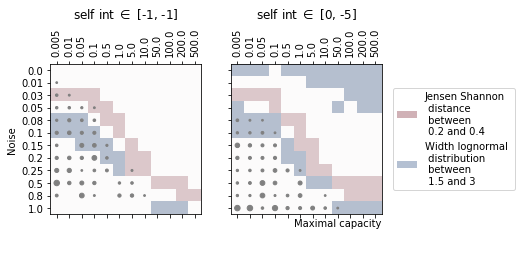

In [59]:
self_int_bounds = [[-1,-1], [-0.1,-5]] #[-5,-5], 
fig = plt.figure(figsize=(8,4), tight_layout=True)
#gs = gridspec.GridSpec(2, 2) #, right=0.7)
#gs_legend = gridspec.GridSpec(1, 1, left=0.55, top=0.45)

gs = gridspec.GridSpec(1, 2, right=0.7)
gs_legend = gridspec.GridSpec(1, 1, left=0.75)

constraints = {'noise_max' : 0,  'int_left' : 0, 'int_right' : 0, 
                'growth_rate_left' : 1, 'growth_rate_right' : 1}

for i, self_int_bound in enumerate(self_int_bounds):
    ax = fig.add_subplot(gs[i], sharey=ax if i>0 else None)
    ax.text(0.5, 1.3, 'self int $\in$ [%.d, %.d]' % tuple(self_int_bound), 
                horizontalalignment='center', fontsize=12, transform = ax.transAxes)
    if i > 0:
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        
    constraints['self_int_left'] = self_int_bound[0];
    constraints['self_int_right'] = self_int_bound[1];
    
    mat_JS = df_constraints(dfs['JS'], constraints).pivot_table(values='median', index='noise', columns='max_cap')
        
    mat_w = df_constraints(dfs['width'], constraints).pivot_table(values='median', index='noise', columns='max_cap')
    
    stab = stability_mesh(constraints)
    x, y = np.arange(stab.shape[1]), np.arange(stab.shape[0]); xv, yv = np.meshgrid(x, y)

    assert np.all(mat_JS.index == mat_w.index)
    assert np.all(mat_JS.columns == mat_w.columns)

    JS_mask = (0.2 < mat_JS.to_numpy()) & (mat_JS.to_numpy() < 0.4)

    w_mask = (1.5 < mat_w.to_numpy()) & (mat_w.to_numpy() < 3)

    ax.matshow(JS_mask, alpha=0.3, cmap='Reds')
    ax.matshow(w_mask, alpha=0.3, cmap='Blues')
    ax.scatter(xv, yv, s=stab, color='grey')
    
    ax.set_xticks(range(len(mat_JS.columns)))
    #if i == 0:
    ax.set_xticklabels(mat_JS.columns, rotation=90)
    #else:
    #    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_yticks(range(len(mat_JS.index)))
    ax.set_yticklabels(mat_JS.index)
    
    if i == len(self_int_bounds)-1:
        ax.set_xlabel('Maximal capacity', x=1, ha='right')
    if i == 0 or (len(self_int_bounds) == 0 and i == 1):
        ax.set_ylabel('Noise')
        
ax = fig.add_subplot(gs_legend[0], frameon=False)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

handles = [ Patch(facecolor=plt.cm.get_cmap('Reds')(1.), alpha=0.3, label='Jensen Shannon \n distance \n between \n 0.2 and 0.4'),
            Patch(facecolor=plt.cm.get_cmap('Blues')(1.), alpha=0.3, label='Width lognormal \n distribution \n between \n 1.5 and 3')]

ax.legend(handles=handles, loc='center')

plt.savefig('figures_ra/overlap2.pdf')
plt.show()

## Interactions

Take the equations with the maximal capacity:

\begin{align}
d x_i(t) = \left(\lambda_i + g_i^- x_i(t) + \sum_j \omega_{ij}^- x_i(t) x_j(t) + \gamma(t) \left( g_i^+ x_i(t) + \sum_j \omega_{ij}^+ x_i x_j\right)\right) dt, \\
\gamma(t) = max(0, 1 - \frac{\sum_i x_i(t)}{N_\text{max}}).
\end{align}

We previously saw that for logistic equations (without interactions) that we could simplify this expression to gLV equations. If we now do not ignore interactions, higher order interaction terms remain (but not really, because the interaction only depends on two of the three species):

\begin{align}
d x_i(t) &= \left(\lambda_i + g_i x_i(t) + \sum_j \omega_{ij} x_i(t) x_j(t) - \frac{\sum_k x_k(t)}{\Nmax} \left( g_i^+ x_i(t) + \sum_j \omega_{ij}^+ x_i x_j\right)\right) dt \\
&= \left( \lambda_i + g_i x_i(t) + \sum_j \left( \omega_{ij} - \frac{g_i^+}{\Nmax} \right) x_i(t) x_j(t) - \sum_j \sum_k \frac{\omega_{ij}^+}{\Nmax}  x_i(t) x_j(t) x_k(t) \right) dt
\end{align}

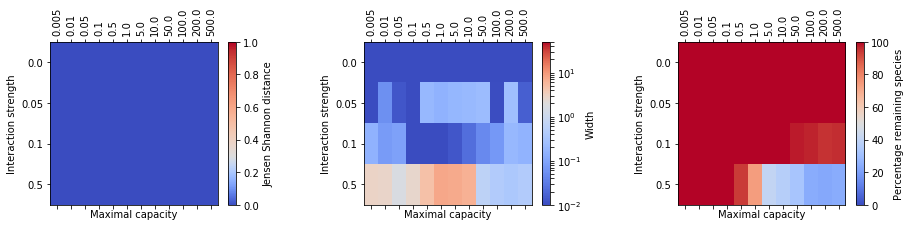

In [11]:
variables = ['JS', 'width', 'number']

constraints = {'noise_max' : 0, 'noise' : 0, 'self_int_left' : -1, 'self_int_right' : -1,
                                  'growth_rate_left' : 1., 'growth_rate_right' : 1.}

fig = plt.figure(figsize=(15,3))
gs = gridspec.GridSpec(1, len(variables), wspace=0.5)
    
for i, var in enumerate(variables):
    df_i = df_constraints(dfs[var], constraints)
    df_i = df_i[df_i['int_right'] == - df_i['int_left']].pivot_table(
        values='median', index='int_right', columns='max_cap')

    # remove values with low p-value
    #if var is 'width':
    #    pvals = df_constraints(dfs['pval'], constraints)
    #    pvals = pvals[pvals['int_right'] == - pvals['int_left']].pivot_table(
    #        values='median', index='int_right', columns='max_cap')
    #    df_i.iloc[pvals.to_numpy(dtype=float) < 0.05] = np.nan

    ax = fig.add_subplot(gs[i])

    mat = ax.matshow(df_i.to_numpy(dtype=float), cmap='coolwarm', norm=normalizations[var], aspect='auto',
                     vmin=normalizations[var].vmin if normalizations[var] != None else None, 
                     vmax=normalizations[var].vmax if normalizations[var] != None else None)

    ax.set_xticks(range(len(df_i.columns)))
    ax.set_xticklabels(df_i.columns, rotation=90)
    ax.set_yticks(range(len(df_i.index)))
    ax.set_yticklabels(df_i.index)
    ax.set_xlabel('Maximal capacity')
    ax.set_ylabel('Interaction strength')
    fig.colorbar(mat, label=labels[var], ax=ax)
plt.show()

The strength of the interactions have no influence on the distance between different timeseries. The predictability depends mostly on the maximal capacity and the noise. The width increases with increasing interaction strength.

Noise 0


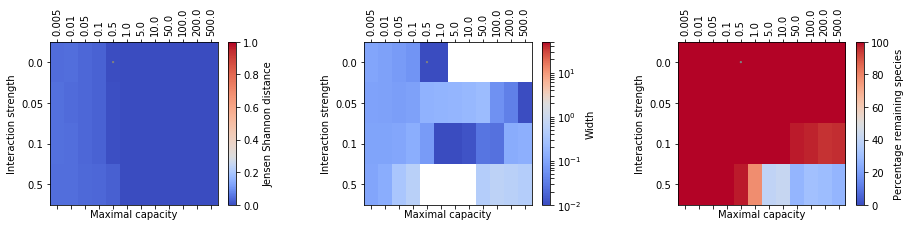

Noise 0.1


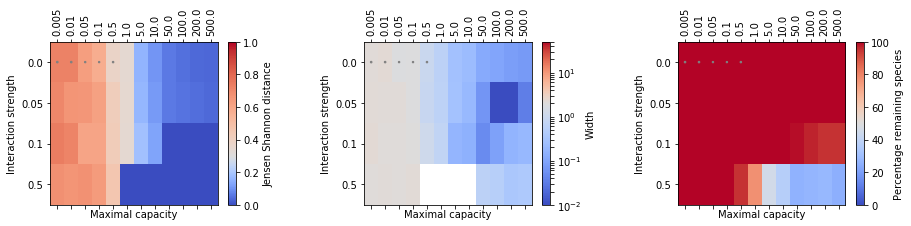

Noise 0.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


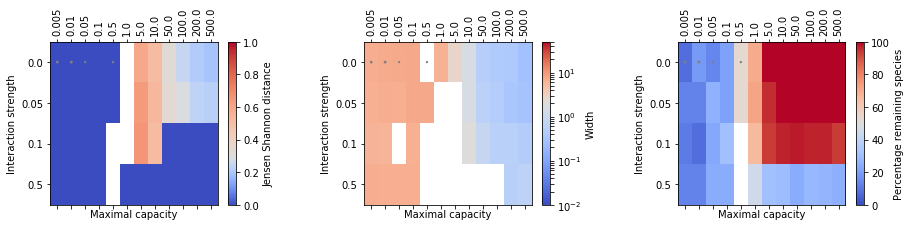

In [14]:
variables = ['JS', 'width', 'number']

noises = [0, 0.1, 0.5]
for noise in noises:
    print('Noise', noise)
    
    constraints = {'noise_max' : 0, 'noise' : noise, 'self_int_left' : -1, 'self_int_right' : -1,
                                  'growth_rate_left' : 1., 'growth_rate_right' : 1.}

    fig = plt.figure(figsize=(15,3))
    gs = gridspec.GridSpec(1, len(variables), wspace=0.5)
    
    stab = stability_mesh(constraints)
    
    x, y = np.arange(stab.shape[1]), np.arange(stab.shape[0]); xv, yv = np.meshgrid(x, y)

    for i, var in enumerate(variables):
        df_i = df_constraints(dfs[var], constraints)
        df_i = df_i[df_i['int_right'] == - df_i['int_left']].pivot_table(
            values='median', index='int_right', columns='max_cap')

        # remove values with low p-value
        if var is 'width':
            pvals = df_constraints(dfs['pval'], constraints)
            pvals = pvals[pvals['int_right'] == - pvals['int_left']].pivot_table(
                values='median', index='int_right', columns='max_cap')
            df_i.iloc[pvals.to_numpy(dtype=float) < 0.05] = np.nan
            
        ax = fig.add_subplot(gs[i])
        
        mat = ax.matshow(df_i.to_numpy(dtype=float), cmap='coolwarm', norm=normalizations[var], aspect='auto',
                         vmin=normalizations[var].vmin if normalizations[var] != None else None, 
                         vmax=normalizations[var].vmax if normalizations[var] != None else None)
        ax.scatter(xv, yv, s=stab, color='grey')
        
        ax.set_xticks(range(len(df_i.columns)))
        ax.set_xticklabels(df_i.columns, rotation=90)
        ax.set_yticks(range(len(df_i.index)))
        ax.set_yticklabels(df_i.index)
        ax.set_xlabel('Maximal capacity')
        ax.set_ylabel('Interaction strength')
        fig.colorbar(mat, label=labels[var], ax=ax)
    plt.show()

Noise : 0.1, interaction strength: 0.1, maximal capacity : 0.01
0.746931333919705
0.9798735421947984
0.8360772500359326
0.9502174829187485
0.8913532780555503
Noise : 0.1, interaction strength: 0.2, maximal capacity : 30.0
4.15735323981386e+22
4.522886403655155e+19
3.6897186303792347e+42
6.752629470958921e+29
9.554114874313426e+26


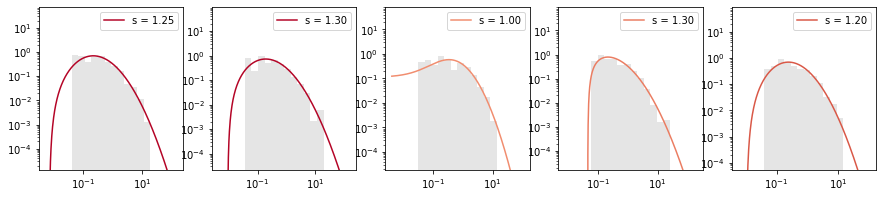

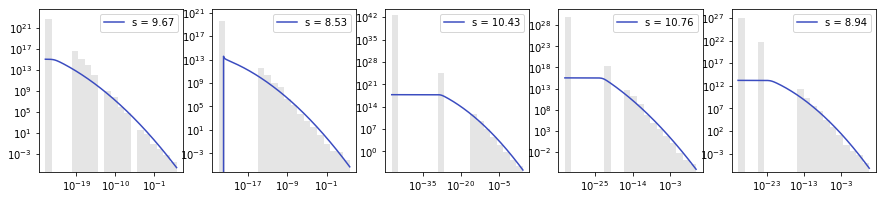

In [39]:
print('Noise : 0.1, interaction strength: 0.1, maximal capacity : 0.01')

con = {'noise_max' : 0., 'max_cap' : 0.01, 'self_int_left' : -1., 'self_int_right' : -1.,
'int_left' : -0.1, 'int_right' : 0.1, 'growth_rate_left' : 1., 'growth_rate_right' : 1., 'noise': 0.1}

plot_distributions(con)
plt.show()

print('Noise : 0.1, interaction strength: 0.2, maximal capacity : 30.0')

con = {'noise_max' : 0., 'max_cap' : 30.0, 'self_int_left' : -1., 'self_int_right' : -1.,
'int_left' : -0.2, 'int_right' : 0.2, 'growth_rate_left' : 1., 'growth_rate_right' : 1., 'noise': 0.1}

plot_distributions(con)
df = plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


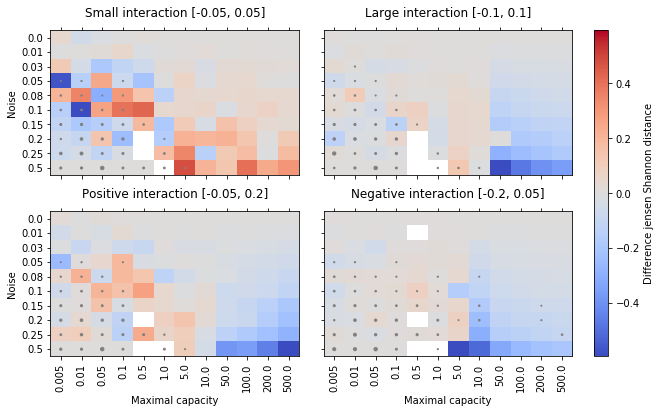

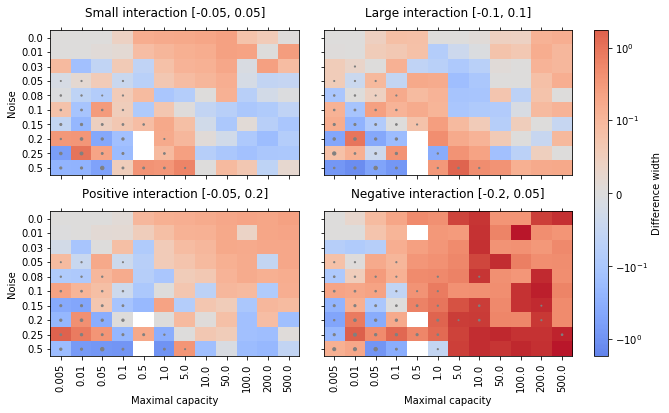

In [18]:
variables = ['JS', 'width']
fignames = ['figures_ra/JS-interaction.pdf', 'figures_ra/width-interaction.pdf']

constraints1 = {'noise_max' : 0, 'self_int_left' : -1, 'self_int_right' : -1,
                                  'int_left' : 0, 'int_right' : 0, 
                                  'growth_rate_left' : 1, 'growth_rate_right' : 1}

stab1 = stability_mesh(constraints1)
x, y = np.arange(stab1.shape[1]), np.arange(stab1.shape[0]); xv, yv = np.meshgrid(x, y)

for var, figname in zip(variables, fignames):
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.25, right=0.85)
    gs_cbar = gridspec.GridSpec(1, 1, left=0.88)

    int_bounds = [[-0.05, 0.05], [-0.1, 0.1], [-0.05, 0.2], [-0.2, 0.05]]
    titles = ['Small interaction [-0.05, 0.05]', 'Large interaction [-0.1, 0.1]', 
             'Positive interaction [-0.05, 0.2]', 'Negative interaction [-0.2, 0.05]']

    df1 = df_constraints(dfs[var], constraints1).pivot_table(values='median', index='noise', columns='max_cap')

    for i, int_bound, title in zip(count(), int_bounds, titles):
        ax = fig.add_subplot(gs[i])
        ax.set_title(title)
        
        constraints2 = constraints1.copy()
        constraints2['int_left'], constraints2['int_right'] = int_bound 
        
        df2 = df_constraints(dfs[var], constraints2).pivot_table(values='median', index='noise', columns='max_cap')

        assert np.all(df1.index == df2.index) and np.all(df1.columns == df2.columns)

        diff = df2.to_numpy(dtype=float) - df1.to_numpy(dtype=float)
        
        stab2 = stability_mesh(constraints2)
        stab_comp = np.maximum(stab1, stab2)
        
        if normalizations['diff_'+var] == None:
            vmin, vmax = np.nanmin(diff), np.nanmax(diff)
            vmin = min(vmin, -vmax); vmax = -vmin
        else:
            vmin=normalizations['diff_'+var].vmin
            vmax=normalizations['diff_'+var].vmax
        
        ax_mat = ax.matshow(diff, cmap='coolwarm', vmin=vmin, vmax=vmax, 
                            norm=normalizations['diff_'+var], aspect='auto')
        ax.scatter(xv, yv, s=stab_comp, color='grey')
        ax.set_xticks(range(len(df1.columns)))
        if i >= 2:
            ax.set_xticklabels(df1.columns, rotation=90)
            ax.tick_params(labelbottom=True, labeltop=False)
            ax.set_xlabel('Maximal capacity')
        else:
            ax.tick_params(labelbottom=False, labeltop=False)

        ax.set_yticks(range(len(df1.index)))
        if i % 2 == 0:
            ax.set_yticklabels(df1.index)
            ax.set_ylabel('Noise')
        else:
            ax.tick_params(labelleft=False)

    ax = fig.add_subplot(gs_cbar[0])
    fig.colorbar(ax_mat, label=labels['diff_'+var], cax=ax, ticks=ticks['diff_'+var])
    
    #plt.savefig(figname)
plt.show()

## What is the largest stable width we can obtain?

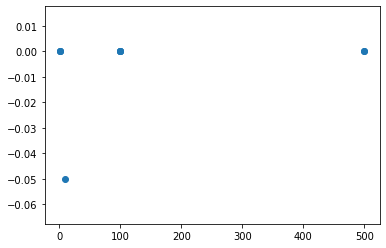

       noise_max  noise  self_int_left  self_int_right  growth_rate_left  \
9203           0   0.50           -1.0            -1.0               1.0   
11043          0   0.00           -0.1            -5.0               1.0   
11295          0   0.20           -0.1            -5.0               1.0   
11403          1   0.00           -0.1            -5.0               1.0   
11757          0   0.00           -0.1            -5.0               1.0   
11805          0   0.01           -0.1            -5.0               1.0   
12117          1   0.00           -0.1            -5.0               1.0   
12165          1   0.01           -0.1            -5.0               1.0   
12189          1   0.03           -0.1            -5.0               1.0   
12225          1   0.05           -0.1            -5.0               1.0   

       growth_rate_right  max_cap  int_left  int_right     mean_stab  \
9203                 1.0     10.0     -0.05       0.05 -1.331440e-03   
11043              

In [11]:
new_df = pd.merge(dfs['stability'], dfs['width'],  on=['noise_max', 'noise', 'self_int_left', 'self_int_right',
       'growth_rate_left', 'growth_rate_right', 'max_cap', 'int_left',
       'int_right'], suffixes=['_stab','_width'])

new_df = new_df[new_df['max_stab'].abs() < 1e-3]
#new_df = new_df.sort_values('mean_width', ascending=False)
new_df = new_df[np.logical_and(1.5 < new_df['min_width'], new_df['max_width'] < 3)]

N = 300
a = new_df.max_cap[:N]
b = new_df.int_left[:N]

plt.scatter(a, b)
plt.show()

print(b.value_counts())

In [13]:
new_df

,noise_max,noise,self_int_left,self_int_right,growth_rate_left,growth_rate_right,max_cap,int_left,int_right,mean_stab,median_stab,std_stab,min_stab,max_stab,mean_width,median_width,std_width,min_width,max_width
9203,0,0.50,-1.0,-1.0,1.0,1.0,10.0,-0.05,0.05,-1.331440e-03,-6.711000e-04,1.496027e-03,-3.690000e-03,3.977000e-04,1.6728,1.577,0.154049,1.547,1.956
11043,0,0.00,-0.1,-5.0,1.0,1.0,1.0,0.00,0.00,7.736000e-05,6.943000e-05,3.195968e-05,3.333000e-05,1.276000e-04,1.6738,1.712,0.116099,1.504,1.809
11295,0,0.20,-0.1,-5.0,1.0,1.0,1.0,0.00,0.00,-4.736600e-04,-3.163000e-04,5.498795e-04,-1.421000e-03,2.120000e-04,1.7640,1.790,0.150228,1.572,1.946
11403,1,0.00,-0.1,-5.0,1.0,1.0,1.0,0.00,0.00,7.736000e-05,6.943000e-05,3.195968e-05,3.333000e-05,1.276000e-04,1.6738,1.712,0.116099,1.504,1.809
11757,0,0.00,-0.1,-5.0,1.0,1.0,100.0,0.00,0.00,1.394160e-18,1.372000e-18,7.299163e-19,2.588000e-19,2.455000e-18,1.6626,1.655,0.061995,1.573,1.764
11805,0,0.01,-0.1,-5.0,1.0,1.0,500.0,0.00,0.00,1.392800e-05,-3.016000e-05,7.247511e-05,-3.494000e-05,1.542000e-04,1.7442,1.739,0.084075,1.636,1.893
12117,1,0.00,-0.1,-5.0,1.0,1.0,100.0,0.00,0.00,1.394160e-18,1.372000e-18,7.299163e-19,2.588000e-19,2.455000e-18,1.6626,1.655,0.061995,1.573,1.764
12165,1,0.01,-0.1,-5.0,1.0,1.0,500.0,0.00,0.00,-4.661600e-05,-6.248000e-05,5.231899e-05,-9.534000e-05,5.382000e-05,1.7068,1.660,0.077785,1.633,1.845
12189,1,0.03,-0.1,-5.0,1.0,1.0,100.0,0.00,0.00,8.053000e-05,6.635000e-05,2.722054e-04,-3.383000e-04,4.134000e-04,1.6084,1.608,0.034168,1.561,1.667
12225,1,0.05,-0.1,-5.0,1.0,1.0,100.0,0.00,0.00,1.164600e-04,1.878000e-04,1.399788e-04,-1.557000e-04,2.320000e-04,1.6178,1.595,0.045102,1.575,1.696


In [72]:
tsa, tsb = two_timeseries([-0.1, -5], [1,1], 10, 0., [0,0], noise_implementation=NOISE.LANGEVIN_LINEAR, rand_int=0, model=MODEL.MAX)
tsc, tsd = two_timeseries([-0.1, -5], [1,1], 100, 0., [0,0], noise_implementation=NOISE.LANGEVIN_LINEAR, rand_int=0, model=MODEL.GLV)

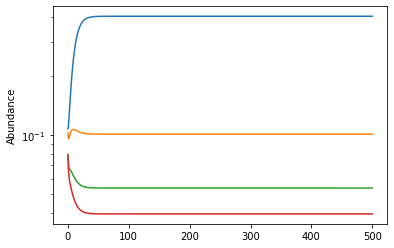

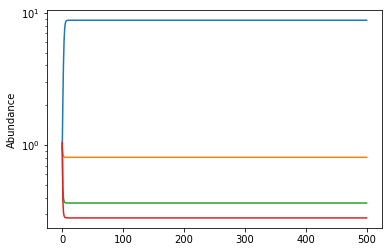

In [73]:
PlotTimeseries(tsa.timeseries)
PlotTimeseries(tsc.timeseries)

Jensen Shannon distance 0.3818424037230817


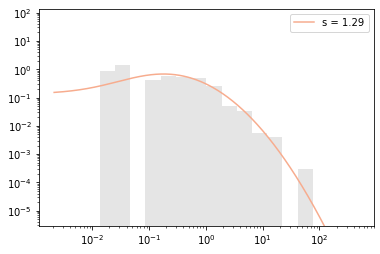

In [51]:
raa = tsa.endpoint.to_numpy().flatten()
rab = tsb.endpoint.to_numpy().flatten()

params = fit_heavytail(ra)
plot_heavytail(ra, params)
plt.yscale('log')

print("Jensen Shannon distance", JensenShannon(raa, rab))

In [76]:
N = 100

params = {}

max_cap = 1

omega = np.random.uniform(0, 0, [N, N])
np.fill_diagonal(omega, np.random.uniform(-0.1, -5, [N, 1]))
params['interaction_matrix'] = omega
params['immigration_rate'] = np.zeros([N, 1])
params['growth_rate'] = np.random.uniform(1, 1, [N, 1])
params['initial_condition'] = np.random.normal(1, 0.1, [N, 1])
params['noise_linear'] = 0

ss = np.full([N,1], max_cap / N)
params['maximum_capacity'] = max_cap

params['noise_linear'] = 0

print(-np.linalg.inv(omega).dot(params['growth_rate']))

if False:
    dt = 0.01
    tskip = 49
    T = 501.0

    ts = {}

    params['initial_condition'] = ss * np.random.normal(1, 0.1, [N, 1])
    ts1 = glv.Timeseries(params, noise_implementation=noise_implementation, dt=dt, tskip=tskip, T=T,
                                seed=int(time.time())+rand_int, model=model)


[[1.18846312]
 [0.57140597]
 [0.36279338]
 [0.3312921 ]
 [0.25312756]
 [3.92170386]
 [0.48709588]
 [2.31846963]
 [0.21271266]
 [5.92389485]
 [0.25808189]
 [0.2047348 ]
 [1.20003421]
 [0.23857933]
 [3.94072419]
 [0.67523728]
 [0.24463369]
 [0.33567996]
 [0.54069454]
 [2.36689986]
 [0.83441118]
 [1.28195086]
 [0.27028711]
 [0.45376005]
 [1.00084919]
 [6.26772395]
 [0.22766846]
 [0.3287111 ]
 [5.91400767]
 [0.3034412 ]
 [0.20087655]
 [0.28717422]
 [0.93727189]
 [0.46963909]
 [0.42830198]
 [0.24445443]
 [0.38669686]
 [0.5807317 ]
 [0.64741743]
 [7.20783653]
 [5.06253739]
 [0.92565361]
 [0.34696288]
 [0.20973351]
 [0.38715445]
 [0.22810639]
 [0.29003693]
 [4.67078936]
 [1.92237858]
 [0.25356162]
 [1.02480579]
 [0.30600294]
 [0.51614601]
 [0.68501634]
 [0.70390743]
 [1.25097526]
 [3.34613235]
 [0.39157648]
 [0.52129171]
 [0.77111   ]
 [0.25214335]
 [0.26556166]
 [0.21495303]
 [0.23810013]
 [0.39273584]
 [0.23208911]
 [0.42307919]
 [0.32032138]
 [0.75175004]
 [2.07660841]
 [0.33529172]
 [0.20